# Тестовое задание для ГК Самолет

In [1518]:
import pandas as pd
import numpy as np
import os
import datetime
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, auc, roc_curve

import gensim.downloader as api
from multiprocessing import cpu_count
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfTransformer

from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import ttest_ind

In [563]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.max_rows', 10)

## Оглавление: 

* [Постановка задачи](#Постановка-задачи)
* [Решение задачи классификации](#Решение-задачи-классификации)
    * [Построение и отбор признаков](#Построение-и-отбор-признаков)
        * [word2vec](##word2vec)
        * [tf-idf](##tf-idf)
        * [Сезонность](##Сезонность)
        * ["Экспертное мнение"](##"Экспертное-мнение")
    * [Подбор параметров](#Подбор-параметров-модели)
    * [Сравнение моделей](#Сравнение-моделей)
    * [Итоги](#Итоги)
    

# Постановка задачи

Задача - определение пола абонента на основании банковских транзакционных данных .

Для каждого клиента банка из файла test_set.csv проставьте предиктив пола абонента по следующему примеру: 

client_id;gender_prediction  
61240380;1  
34114030;0  
61240380;0  
34114031;1  

Файлы:  
types.csv  - справочник типов транзакций  
codes.csv - справочник кодов транзакций  
transactions.csv - транзакционные данные по банковским операциям  
train_set.csv - тренировочный сет с разметкой пола абонента(0/1  - пол абонента)  
test_set.csv - тестовый сет, который необходимо разметить  


Описание полей для файла transactions.csv:  

client_id - id клиента банка  
datetime - дата транзакции(формат - порядковый_номер_дня час:минута:секунда.пример - 421 06:33:15)  
code - номер кода транзакции  
type - номер типа транзакции  
sum - сумма транзакции  

In [625]:
train_set = pd.read_csv('train_set.csv', sep=';')
test_set = pd.read_csv('test_set.csv', sep=';')
codes = pd.read_csv('codes.csv', sep=';')
types = pd.read_csv('types.csv', sep=';')
transactions = pd.read_csv('transactions.csv', sep=';')

In [626]:
train_set, test_set

(      client_id  target
 0      75063019       0
 1      86227647       1
 2       6506523       0
 3      50615998       0
 4      95213230       0
 ...         ...     ...
 5995   71577803       0
 5996    8128547       1
 5997   26055781       0
 5998   73504380       1
 5999    1846496       0
 
 [6000 rows x 2 columns],
       client_id
 0      61240380
 1      34114030
 2      15926722
 3      50598019
 4      76475250
 ...         ...
 2651   13491189
 2652   54047312
 2653   68859452
 2654   95721840
 2655    4022959
 
 [2656 rows x 1 columns])

In [627]:
codes

,code,code_description
0,5944,"Магазины по продаже часов, ювелирных изделий и..."
1,5621,Готовые сумочные изделия
2,5697,"Услуги по переделке, починке и пошиву одежды"
3,7995,Транзакции по азартным играм
4,5137,"Мужская, женская и детская спец-одежда"
...,...,...
179,5044,"Офисное, фотографическое, фотокопировальное, и..."
180,5983,"Горючее топливо — уголь, нефть, разжиженный бе..."
181,5994,Дилеры по продаже печатной продукции
182,5192,"Книги, периодические издания и газеты"


In [628]:
pd.unique(codes.code_description).shape

(184,)

In [629]:
types

,type,type_description
0,8001,Установление расх. лимита по карте
1,2411,Перевод с карты на счет др.лица в одном тер. б...
2,4035,н/д(нет данных)
3,3001,Комиссия за обслуживание ссудного счета
4,2420,Перевод с карты на счет физ.лица в другом тер....
...,...,...
150,4110,Плата за получение наличных в АТМ.
151,2320,Безналичный перевод денежных средств через POS
152,7040,Перевод на карту (с карты) через POS (в предел...
153,2433,Перевод с карты на счет физ.лица в другом банк...


In [630]:
pd.unique(types.type_description).shape

(139,)

In [631]:
transactions.head(10)

,client_id,datetime,code,type,sum
0,96372458,421 06:33:15,6011,2010,-561478.94
1,24567813,377 17:20:40,6011,7010,67377.47
2,21717441,55 13:38:47,6011,2010,-44918.32
3,14331004,263 12:57:08,6011,2010,-3368873.66
4,85302434,151 10:34:12,4814,1030,-3368.87
5,31421357,398 00:00:00,5411,1110,-1572.14
6,84826852,423 15:27:55,6010,7070,5654.99
7,92322336,66 13:21:29,4814,1030,-4491.83
8,91101111,346 11:06:20,4814,1030,-4491.83
9,48933372,157 15:22:24,5921,1010,-7703.49


In [632]:
transactions.dtypes

client_id      int64
datetime      object
code           int64
type           int64
sum          float64
dtype: object

Типы данных:  
datetime - время  
code - категориальный признак  
type - категориальный признак  
sum - вещественное число  

code - 184 категории кодов транзакций  
type - 155 категории типов транзакций  

Рассмотрим единственный вещественный признак - сумму транзакции:

In [633]:
transactions['sum'].describe()

count    1.300390e+05
mean    -1.812909e+04
std      5.584445e+05
min     -4.150030e+07
25%     -2.244916e+04
50%     -5.502490e+03
75%     -1.122960e+03
max      6.737747e+07
Name: sum, dtype: float64

Видим, что суммы транзакции принимают как отрицательные, так и положительные значения.

In [473]:
print(transactions.loc[0])
types[types.type == transactions.loc[0].type], codes[codes.code == transactions.loc[0].code]

client_id        96372458
datetime     421 06:33:15
code                 6011
type                 2010
sum               -561479
Name: 0, dtype: object


(    type       type_description
 87  2010  Выдача наличных в АТМ,
     code                                   code_description
 69  6011  Финансовые институты — снятие наличности автом...)

In [474]:
print(transactions.loc[1])
types[types.type == transactions.loc[1].type], codes[codes.code == transactions.loc[1].code]

client_id        24567813
datetime     377 17:20:40
code                 6011
type                 7010
sum               67377.5
Name: 1, dtype: object


(    type                              type_description
 20  7010  Взнос наличных через АТМ (в своем тер.банке),
     code                                   code_description
 69  6011  Финансовые институты — снятие наличности автом...)

Из приведенных примеров становится ясно, что отрицательные суммы - это расходные категории, а положительные - доходные.

In [475]:
clients = np.concatenate([train_set.client_id, test_set.client_id])
len(set(clients)), len(set(transactions.client_id))

(8656, 8656)

Из приведенной проверки понимаем, что все id клиентов присутствуют в основной таблице транзакций.

In [476]:
transactions[transactions.isnull().any(1)]

,client_id,datetime,code,type,sum


Пропущенные значения в таблице отсутствуют.

In [857]:
train = train_set.merge(transactions, how = 'left', left_on = 'client_id', right_on = 'client_id')
train.head()

,client_id,target,datetime,code,type,sum
0,75063019,0,397 20:05:07,4814,1030,-4491.83
1,75063019,0,86 20:29:50,6010,7070,4491.83
2,75063019,0,375 16:00:33,4814,1030,-3144.28
3,75063019,0,136 17:10:60,5411,1010,-3930.35
4,75063019,0,378 13:01:51,6011,2010,-4491.83


Рассмотрим разбивку транзакций по категориям (рис.1) и типам (рис.2).

,code,code_description,client_id
65,6011,Финансовые институты — снятие наличности автом...,19538
143,6010,Финансовые институты — снятие наличности вручную,14093
72,4814,"Звонки с использованием телефонов, считывающих...",13044
159,5411,"Бакалейные магазины, супермаркеты",13003
154,4829,Денежные переводы,8134
73,5499,"Различные продовольственные магазины — рынки, ...",4456
46,5912,Аптеки,1862
49,5541,Станции техобслуживания,1831
144,5331,Универсальные магазины,1687
81,5812,"Места общественного питания, рестораны",1448


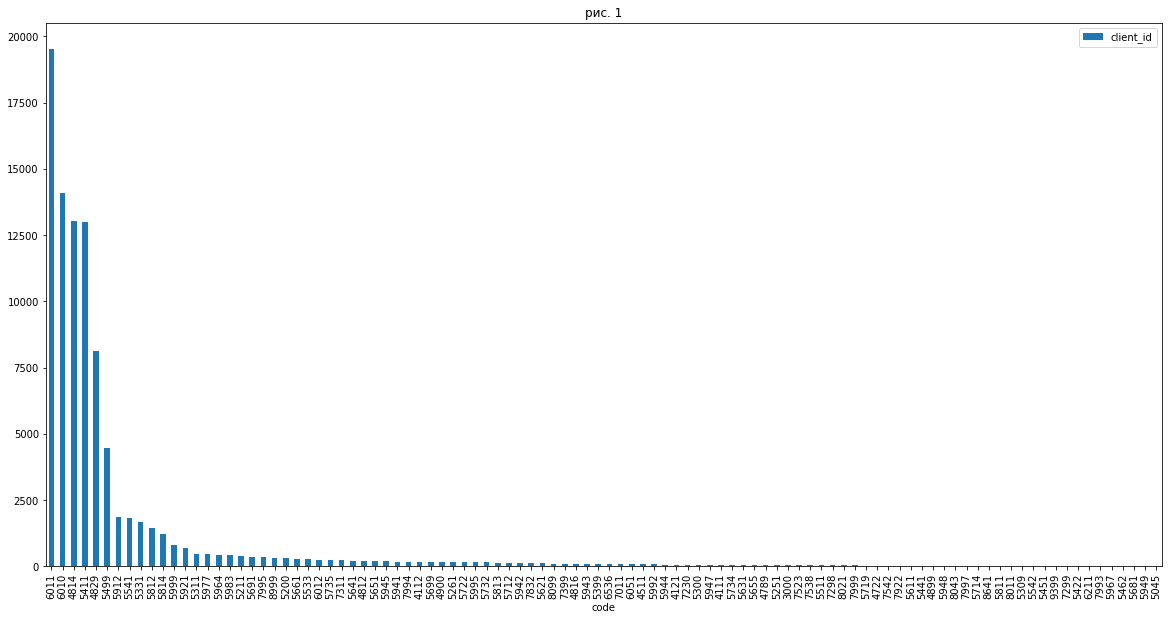

In [479]:
pd.set_option('display.max_rows', None)
hist_ = pd.merge(codes, train.groupby('code').count(), 
                 left_on='code', 
                 right_on='code', 
                 how='inner').sort_values('client_id', ascending=False).loc[:,['code','code_description', 'client_id']]
hist_[:100].plot(x='code', kind='bar', title='рис. 1')
hist_

,type,type_description,client_id
41,1010,Покупка. POS,21427
29,2010,Выдача наличных в АТМ,14135
16,1030,Оплата услуги. Банкоматы,12848
34,1110,Покупка. POS,12276
7,7070,Перевод на карту (с карты) через Мобильный бан...,9808
13,2370,Списание с карты на карту по операции <перевод...,4788
6,7010,Взнос наличных через АТМ (в своем тер.банке),3529
32,7030,Перевод на карту (с карты) через АТМ (в предел...,2092
27,1100,Покупка.,1492
1,1200,Покупка. Зарубеж.,1251


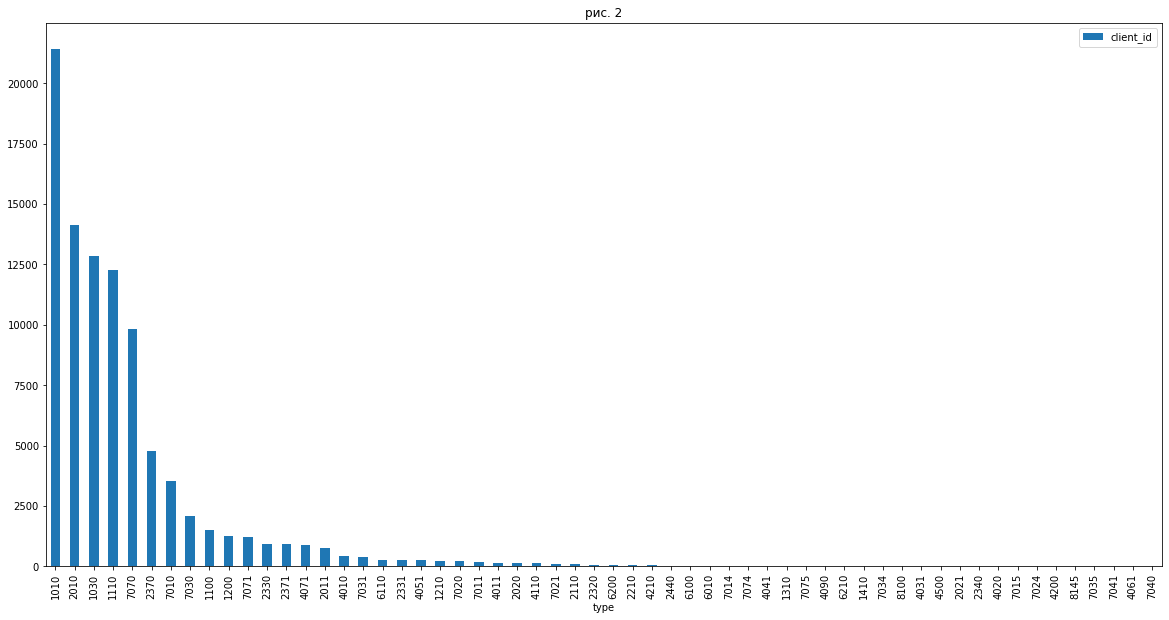

In [480]:
pd.set_option('display.max_rows', None)
hist_ = pd.merge(types, train.groupby('type').count(), 
                 left_on='type', 
                 right_on='type', 
                 how='inner').sort_values('client_id', ascending=False).loc[:,['type','type_description', 'client_id']]
hist_.plot(x='type', kind='bar', title='рис. 2')
hist_

Определим баланс транзакций по целевому признаку (рис.3).

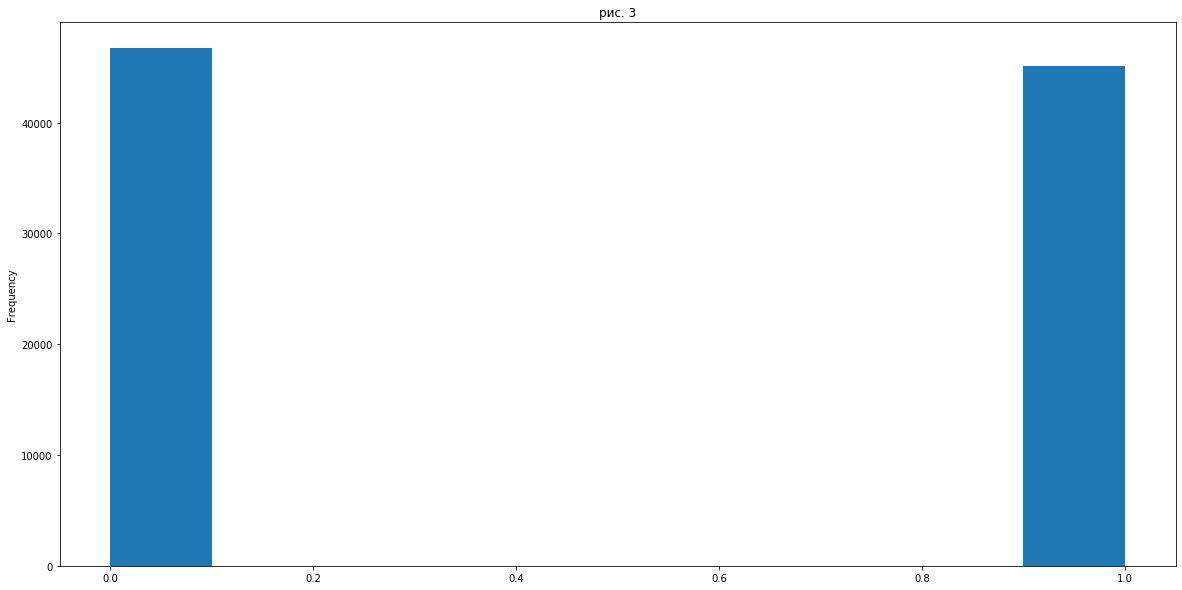

In [482]:
train.target.plot(kind='hist', title='рис. 3')

Определим баланс пола клиентов в выборке (рис.4).

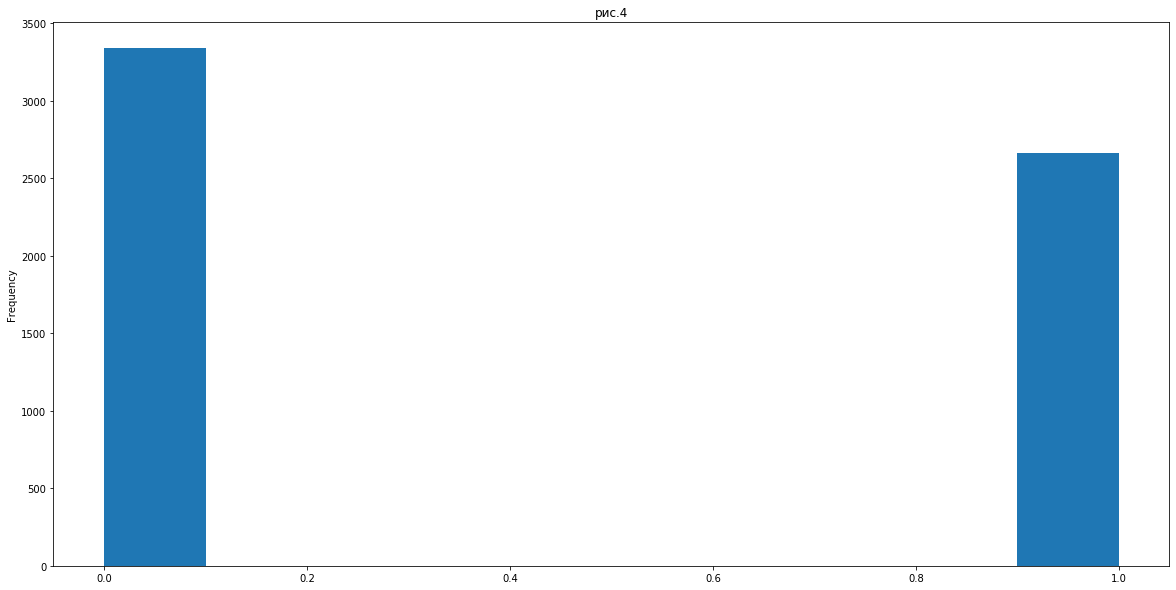

In [483]:
train_set.target.plot(kind='hist', title='рис. 4')

Рассмотрим количество транзацкий каждого пола в категориях(рис. 5) и в типах(рис. 6).

In [485]:
train.code = train.code.astype(str)
train.type = train.type.astype(str)

In [486]:
vals = [df['code'].values for i, df in train[['code', 'target']].groupby('target')]
vals

[array(['4814', '6010', '4814', ..., '5732', '6010', '5411'], dtype=object),
 array(['5411', '6011', '6011', ..., '4814', '4814', '5211'], dtype=object)]

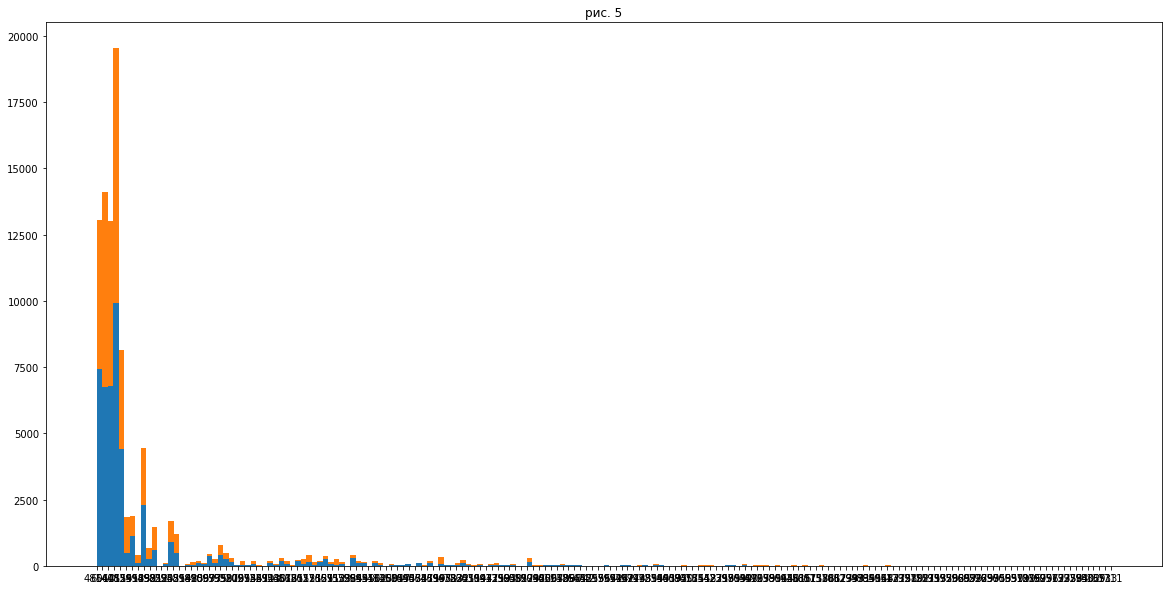

In [488]:
plt.title('рис. 5')
_, _, _ = plt.hist(vals, 184, stacked=True)

In [489]:
vals = [df['type'].values for i, df in train[['type', 'target']].groupby('target')]
vals

[array(['1030', '7070', '1030', ..., '1010', '7030', '1010'], dtype=object),
 array(['1110', '2010', '7010', ..., '1030', '1030', '1010'], dtype=object)]

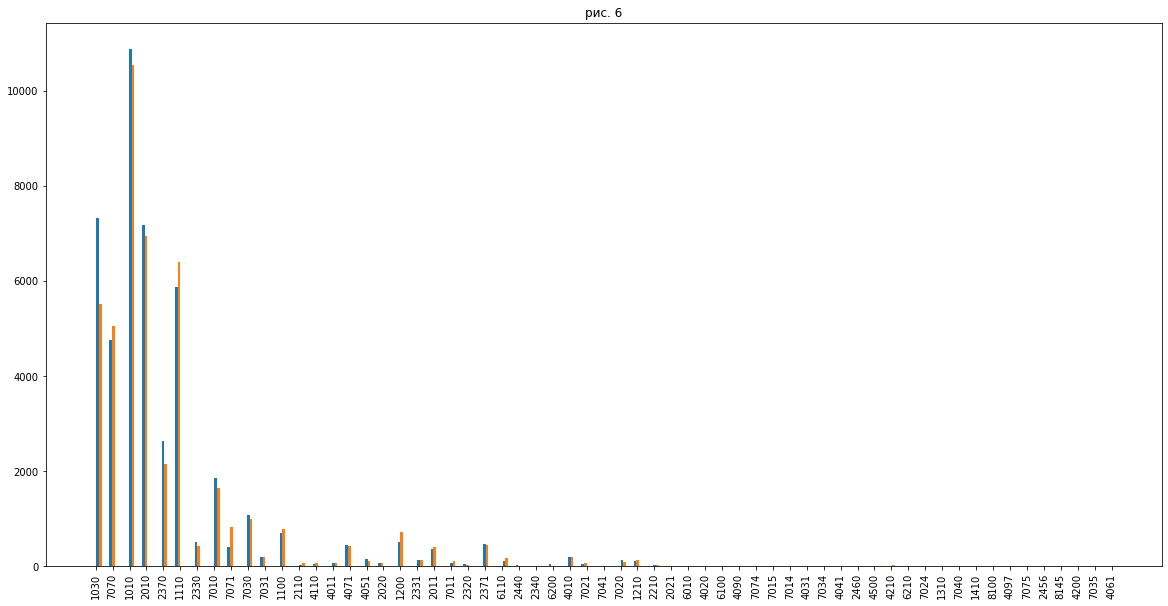

In [490]:
plt.title('рис. 6')
plt.xticks(rotation=90)
_, _, _ = plt.hist(vals, 155)
        #, stacked=True)

# Решение задачи классификации

In [561]:
train.code = train.code.astype(int)
train.type = train.type.astype(int)

Исследуеиые данные - это набор id клиентов с указанием пола, а так же множество транзацкий каждого клиента. Транзакция описывается категорией, типом и суммой затрат либо поступлений. Для дальнейшего решения задачи классификации данные такого вида не подходят. 
1. Тип \ категория - категориальный признак, представленный в виде целых положительных чисел (кодов). 
2. Нет представления клиента (примером является транзакция).
3. Временной признак плохо учтим. 

В первом эксперименте попробуем не учитывать категориальность признака тип \ категория, игнорировать временной признак, а до уровня клиента спускаться при помощи усреднения меток транзакций (размечаем транзакции, а не клиентов). 
В качесте классификационного алгоритма используем **дерево принятия решений**.

In [865]:
kf = KFold()
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
#Разобъем тренировочную выборку на 5 частей
for train_i, test_i in kf.split(train):
    dt = DecisionTreeClassifier()
    #Тренируем модель для распознавания пола транзакции
    dt.fit(train.loc[train_i, ~train.columns.isin(['target', 'datetime'])], train.loc[train_i, 'target'])
    target_pred = dt.predict(train.loc[test_i, ~train.columns.isin(['target', 'datetime'])])
    
    #Сопоставим id клиента с предсказанием пола транзакции клиента
    inter_pred = pd.DataFrame([train.loc[test_i, 'client_id'].values, target_pred], index = ['client_id', 'target']).T
    #Усредним предсказание по клиенту
    inter_pred = inter_pred.groupby(by='client_id').mean()
    #Определим предсказание пола клиента
    inter_pred.target[inter_pred.target>0.5] = 1
    inter_pred.target[inter_pred.target<=0.5] = 0
    inter_pred.target = inter_pred.target.astype(int)
    
    #Определим действительный пол клиента
    inter_test = train.loc[test_i, ['client_id', 'target']]
    inter_test = inter_test.groupby(by='client_id').mean()
    inter_test.target = inter_test.target.astype(int)
    
    inter = inter_test.merge(inter_pred, how = 'inner', left_on='client_id', right_on='client_id')
    #Рассмотрим матрицу ошибок
    print(confusion_matrix(inter.target_y.values, inter.target_x.values))
    #Высчитаем показатели для метрики auc
    fpr, tpr, thresholds = roc_curve(inter.target_x.values, inter.target_y.values)
    #Расчитаем значения метрик оценки эффективности модели
    res = res.append({
            'accuracy': accuracy_score(inter.target_y.values, inter.target_x.values), 
            'recall': recall_score(inter.target_y.values, inter.target_x.values, average='macro'), 
            'f1': f1_score(inter.target_y.values, inter.target_x.values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[387 276]
 [325 254]]
[0.         0.45646067 1.        ] [0.         0.47924528 1.        ]
[[398 334]
 [323 225]]
[0.        0.4479889 1.       ] [0.         0.40250447 1.        ]
[[340 279]
 [232 219]]
[0.         0.40559441 1.        ] [0.         0.43975904 1.        ]
[[383 321]
 [275 209]]
[0.         0.41793313 1.        ] [0.         0.39433962 1.        ]
[[398 292]
 [280 254]]
[0.         0.41297935 1.        ] [0.         0.46520147 1.        ]


,accuracy,recall,f1,auc
0,0.516103,0.511199,0.510490,0.511392
1,0.486719,0.477150,0.477168,0.477258
2,0.522430,0.517430,0.516244,0.517082
3,0.498316,0.487926,0.487319,0.488203
4,0.532680,0.526234,0.526121,0.526111


In [866]:
res.mean(), res.std()

(accuracy    0.511250
 recall      0.503988
 f1          0.503468
 auc         0.504009
 dtype: float64,
 accuracy    0.018553
 recall      0.020651
 f1          0.020483
 auc         0.020490
 dtype: float64)

Воспользуемся более сложным подходом - применим ансамблирование. В качестве метода будем использовать бустинг, а именно его модификацию и реализацию от Яндекса - библиотеку **CatBoost**. При использовании данного алгоритма появляется возможность рассмотрения признаков тип\категория как категориальных. До уровня клиента спускаемся при помощи усреднения меток транзакций.

In [867]:
kf = KFold()
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(train):
    cat = CatBoostClassifier(cat_features=['code', 'type', 'client_id'], verbose=False)
    cat.fit(train.loc[train_i, ~train.columns.isin(['target', 'datetime'])], train.loc[train_i, 'target'])
    target_pred = dt.predict(train.loc[test_i, ~train.columns.isin(['target', 'datetime'])])
    
    #Сопоставим id клиента с предсказанием пола транзакции клиента
    inter_pred = pd.DataFrame([train.loc[test_i, 'client_id'].values, target_pred], index = ['client_id', 'target']).T
    #Усредним предсказание по клиенту
    inter_pred = inter_pred.groupby(by='client_id').mean()
    #Определим предсказание пола клиента
    inter_pred.target[inter_pred.target>0.5] = 1
    inter_pred.target[inter_pred.target<=0.5] = 0
    inter_pred.target = inter_pred.target.astype(int)
    
    #Определим действительный пол клиента
    inter_test = train.loc[test_i, ['client_id', 'target']]
    inter_test = inter_test.groupby(by='client_id').mean()
    inter_test.target = inter_test.target.astype(int)
    
    inter = inter_test.merge(inter_pred, how = 'inner', left_on='client_id', right_on='client_id')
    #Рассмотрим матрицу ошибок
    print(confusion_matrix(inter.target_y.values, inter.target_x.values))
    #Высчитаем показатели для метрики auc
    fpr, tpr, thresholds = roc_curve(inter.target_x.values, inter.target_y.values)
    #Расчитаем значения метрик оценки эффективности модели
    res = res.append({
            'accuracy': accuracy_score(inter.target_y.values, inter.target_x.values), 
            'recall': recall_score(inter.target_y.values, inter.target_x.values, average='macro'), 
            'f1': f1_score(inter.target_y.values, inter.target_x.values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[696 503]
 [ 16  27]]
[[706 524]
 [ 15  35]]
[[568 485]
 [  4  13]]
[[646 503]
 [ 12  27]]
[[661 516]
 [ 17  30]]


,accuracy,recall,f1,auc
0,0.582126,0.604195,0.411328,0.514236
1,0.578906,0.636992,0.419337,0.520904
2,0.542991,0.652059,0.374781,0.509556
3,0.566498,0.627268,0.404950,0.516353
4,0.564542,0.599948,0.406924,0.514936


In [868]:
res.mean(), res.std()

(accuracy    0.567013
 recall      0.624092
 f1          0.403464
 auc         0.515197
 dtype: float64,
 accuracy    0.015438
 recall      0.022008
 f1          0.016961
 auc         0.004084
 dtype: float64)

Полученные результаты неоднозначны. Смещение по всем видам метрик слишком высоки. 

# Построение и отбор признаков

При попытке решить задачу кдассификации, временной признак не был использован. Для его дальнейщего введения в моделирование преобразуем исходные данные.

In [869]:
pd.set_option('display.max_rows', 10)
train.sort_values(by=['client_id', 'datetime'])

,client_id,target,datetime,code,type,sum
31228,22899,1,167 09:50:12,4814,1030,-1122.96
31229,22899,1,221 18:54:19,5399,1110,-4626.59
31225,22899,1,231 09:31:53,6011,2110,-6737.75
31233,22899,1,344 11:45:23,6011,7010,44918.32
31226,22899,1,349 16:34:52,6011,4010,-8759.07
...,...,...,...,...,...,...
21536,99985917,0,61 11:42:26,6011,2010,-224591.58
18833,99991245,1,292 11:20:02,5499,1010,-16574.86
18834,99991245,1,306 06:18:20,6011,7010,561478.94
18835,99991245,1,306 06:20:43,6011,7010,92082.55


In [870]:
#Разделим поле datetime на 4 составляющих: дата, как число, часы, минуты, секунды
train['date'] = train.datetime.apply(lambda x: x.split(' ')[0])
train['time1'] = train.datetime.apply(lambda x: x.split(' ')[1].split(':')[0])
train['time2'] = train.datetime.apply(lambda x: x.split(' ')[1].split(':')[1])
train['time3'] = train.datetime.apply(lambda x: x.split(' ')[1].split(':')[2])

In [871]:
train

,client_id,target,datetime,code,type,sum,date,time1,time2,time3
0,75063019,0,397 20:05:07,4814,1030,-4491.83,397,20,05,07
1,75063019,0,86 20:29:50,6010,7070,4491.83,86,20,29,50
2,75063019,0,375 16:00:33,4814,1030,-3144.28,375,16,00,33
3,75063019,0,136 17:10:60,5411,1010,-3930.35,136,17,10,60
4,75063019,0,378 13:01:51,6011,2010,-4491.83,378,13,01,51
...,...,...,...,...,...,...,...,...,...,...
91821,1846496,0,452 00:00:00,5999,1100,-2243.45,452,00,00,00
91822,1846496,0,196 13:59:07,5411,1010,-4783.80,196,13,59,07
91823,1846496,0,186 13:38:15,5732,1010,-112273.33,186,13,38,15
91824,1846496,0,440 16:02:57,6010,7030,168443.68,440,16,02,57


In [872]:
train.date = train.date.astype(int)
train.time1 = train.time1.astype(int)
train.time2 = train.time2.astype(int)
train.time3 = train.time3.astype(int)

In [873]:
train[['date', 'time1', 'time2', 'time3']].describe()

,date,time1,time2,time3
count,91826.000000,91826.000000,91826.000000,91826.000000
mean,243.034467,11.661969,25.968549,26.518328
std,130.188635,6.230120,18.764605,19.146141
min,0.000000,0.000000,0.000000,0.000000
25%,133.000000,8.000000,9.000000,9.000000
50%,250.000000,12.000000,25.000000,26.000000
75%,356.000000,16.000000,42.000000,43.000000
max,456.000000,23.000000,59.000000,60.000000


В секундах имеется 60 единиц, что не соответсвует стандартному представлению. Дата выражена целочисленным типом от 0 дл 456, что тоже не соответствует стандартным представлениям о дате. Предположим, что 0 день - это дата начала отсчета календаря. Преобразуем данные. 

In [874]:
#Переведем 60 секунд в минуту
train.time2[train.time3>=60] = train.time2[train.time3>=60]+1
train.time3[train.time3>=60] = 0

#60 минут в час
train.time1[train.time2>=60] = train.time1[train.time2>=60]+1
train.time2[train.time2>=60] = 0

#24 часа в новый день
train.date[train.time1>=24] = train.date[train.time1>=24]+1
train.time1[train.time1>=24] = 0

train

C:\Users\denet\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\denet\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\denet\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\d

,client_id,target,datetime,code,type,sum,date,time1,time2,time3
0,75063019,0,397 20:05:07,4814,1030,-4491.83,397,20,5,7
1,75063019,0,86 20:29:50,6010,7070,4491.83,86,20,29,50
2,75063019,0,375 16:00:33,4814,1030,-3144.28,375,16,0,33
3,75063019,0,136 17:10:60,5411,1010,-3930.35,136,17,11,0
4,75063019,0,378 13:01:51,6011,2010,-4491.83,378,13,1,51
...,...,...,...,...,...,...,...,...,...,...
91821,1846496,0,452 00:00:00,5999,1100,-2243.45,452,0,0,0
91822,1846496,0,196 13:59:07,5411,1010,-4783.80,196,13,59,7
91823,1846496,0,186 13:38:15,5732,1010,-112273.33,186,13,38,15
91824,1846496,0,440 16:02:57,6010,7030,168443.68,440,16,2,57


In [875]:
#Создадим поле с временем проведения транзакции
train['time0'] = train[['time1', 'time2', 'time3']].T.apply(lambda x: datetime.time(*x))

In [876]:
#Создадим поле с датой проведения транзакции
train['date1'] = pd.to_datetime('20160101') + train.date.apply(lambda x: pd.Timedelta(x, 'd'))

In [877]:
#Поле с датой+временем проведения транзакции
train['datetime0'] = train[['date1', 'time0']].T.apply(lambda x: datetime.datetime.combine(*x))

In [878]:
train

,client_id,target,datetime,code,type,sum,date,time1,time2,time3,time0,date1,datetime0
0,75063019,0,397 20:05:07,4814,1030,-4491.83,397,20,5,7,20:05:07,2017-02-01,2017-02-01 20:05:07
1,75063019,0,86 20:29:50,6010,7070,4491.83,86,20,29,50,20:29:50,2016-03-27,2016-03-27 20:29:50
2,75063019,0,375 16:00:33,4814,1030,-3144.28,375,16,0,33,16:00:33,2017-01-10,2017-01-10 16:00:33
3,75063019,0,136 17:10:60,5411,1010,-3930.35,136,17,11,0,17:11:00,2016-05-16,2016-05-16 17:11:00
4,75063019,0,378 13:01:51,6011,2010,-4491.83,378,13,1,51,13:01:51,2017-01-13,2017-01-13 13:01:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91821,1846496,0,452 00:00:00,5999,1100,-2243.45,452,0,0,0,00:00:00,2017-03-28,2017-03-28 00:00:00
91822,1846496,0,196 13:59:07,5411,1010,-4783.80,196,13,59,7,13:59:07,2016-07-15,2016-07-15 13:59:07
91823,1846496,0,186 13:38:15,5732,1010,-112273.33,186,13,38,15,13:38:15,2016-07-05,2016-07-05 13:38:15
91824,1846496,0,440 16:02:57,6010,7030,168443.68,440,16,2,57,16:02:57,2017-03-16,2017-03-16 16:02:57


## word2vec


Рассмотрим клиента, как историю его трат и поступлений, т.е. как вектор перехода категорий \ типов транзакций. 
Для этого необходимо определить, что такое категория \ тип транзакции в массиве транзакций. Представим тип\ категорию, как некое слово, описывающее транзакцию. А серия транзакций, как текст - предложение, описывающее самого клиента, а его пол - тематика данного "предложения". Для сравнения текстов с друг другом существеют  алгоритмы обработки естественного языка. 

Алгоритм **word2vec** позволяетс расчитывать "смысл" слова, описывая "похожие" по смыслу слова схожими числовыми векторами. Таким образом будет возможно опредеоять схожие категории, и схожие истории переходов транзакций. 

Для этого отсортируем транзакции по дате и сгруппируем по клиентам.

In [880]:
dataset_code = []
dataset_type = []
#Спускаемся на уровень клиента
for i, data in train.groupby(by='client_id'):
    #Сортируем транзакции клиента по дате
    data = data.sort_values(by='datetime0')
    #Создаем вектор категорий транзакций
    data.code = data.code.astype(str)
    dataset_code.append(list(data.code.values))
    #Создаем вектор типов транзакций
    data.type = data.type.astype(str)
    dataset_type.append(list(data.type.values))    

In [881]:
dataset_code[0], dataset_type[0]

(['6010', '5541', '4814', '5399', '6011', '6011', '6011', '6010', '6011'],
 ['7030', '1010', '1030', '1110', '2110', '7010', '4010', '7071', '4010'])

Для каждого клиента получили вектор категорий \ типов, отсортированных по времени проведения транзакции. 
Далее обучим модель и опишем каждого клиента числовым вектором для категорий транзаций и для типов транзакций. 

In [44]:
# Обучение модели Word2Vec для категорий
w2v_model_codes = Word2Vec(dataset_code, min_count=0, workers=cpu_count(), vector_size=50)
# Обучение модели Word2Vec для типов
w2v_model_types = Word2Vec(dataset_type, min_count=0, workers=cpu_count(), vector_size=50)

In [45]:
# вектор для категории 6010 и типа 7030
print(w2v_model_codes.wv['6010'], w2v_model_types.wv['7030'])

[-2.2202528   1.0699766  -1.5386444  -1.3182924   2.3305018  -0.5173033
 -0.64793557 -2.196674   -1.1105391   1.9195409  -2.1160426  -0.7756921
  0.15717413 -3.2986143   0.15568028  1.087772   -0.3265901   1.5767792
 -0.24467374  0.97037727  0.05843542  1.7494553  -0.21872462 -2.2128043
  0.38686898  1.5169404   0.96029556 -0.44192284 -0.65107065 -1.0488784
  1.1447659  -0.57888925 -0.97907495  1.4601393  -1.1079732  -0.1830497
  0.25498053 -0.12558053 -0.82139176  3.6742294   1.2463236  -0.47969618
  1.2585797   2.1938176   3.443064    0.37061644 -1.6343874  -3.5123124
  0.52413404 -0.6684416 ] [ 0.4314433   0.2675044  -1.0681777  -0.6435725  -0.18607534 -0.21559656
 -0.70470494  1.6878185  -0.218823   -0.5287455  -0.2063804  -0.48449603
  2.5666177   0.46714148  0.6355592  -0.667573    0.4898305   1.7387441
 -2.0708122  -2.2539604   0.04333971 -0.13789336  0.27427247  0.25464383
  0.6238787  -0.5644672   0.6404811   1.2046303  -1.6846445   0.8596679
  0.07866399 -0.5041542   0.282006

In [46]:
#Каждую транзакцию описываем вектором его категории
code_ = pd.concat([train[['client_id', 'target']], 
                   pd.DataFrame(train.code.apply(lambda x: pd.Series(w2v_model_codes.wv[str(x)])))],
                  axis=1)
#Усредняем значения, спускаясь на уровень клиента
code_ = code_.groupby(by='client_id').mean()
code_

,target,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
client_id,,,,,,,,,,,,,,,,,,,,,
22899,1,-0.768158,0.400642,-0.348143,-0.005526,0.533399,-0.344744,0.182053,-0.332283,-0.569620,...,0.035952,-0.057372,0.026616,0.323528,1.175541,0.444758,-0.488376,-0.810889,0.219713,0.114830
27914,1,-0.918245,0.492415,-0.392202,-0.037278,0.784816,-0.353054,-0.019267,-0.390621,-0.560420,...,0.059739,-0.076613,-0.137313,0.487159,1.106604,0.583359,-0.400271,-0.833244,0.238726,0.016290
28753,0,-0.218145,0.136666,-0.100434,0.247129,0.206106,-0.095221,0.212819,0.290710,-0.457419,...,0.230101,-0.046899,-0.234478,0.123345,0.407338,0.195579,-0.025160,-0.243471,0.029833,0.296241
38084,0,-0.246337,0.080326,-0.176539,0.319546,0.047407,-0.119249,0.355382,0.237426,-0.546158,...,-0.029891,0.099380,-0.155150,0.008246,0.439413,0.423483,-0.034921,-0.298446,-0.006148,0.196959
49793,1,-0.343534,-0.070356,-0.257633,0.105792,-0.339597,-0.365404,0.393461,0.224036,-0.558450,...,-0.011127,0.225952,-0.091378,-0.278312,0.456977,0.541740,0.247253,-0.087473,0.222849,-0.129275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99900908,0,-0.138978,-0.225731,-0.297995,0.061268,-0.535245,-0.322424,0.526275,0.267100,-0.593224,...,0.219145,0.221526,0.123491,-0.308190,0.494240,0.333710,0.249044,-0.180768,0.185145,-0.134799
99911226,0,-0.144311,-0.076295,-0.092591,0.413396,-0.227672,-0.221993,0.772877,0.449904,-0.543836,...,0.079116,0.124908,-0.083349,-0.167876,0.446382,0.339915,-0.049376,-0.269511,-0.058678,0.302809
99967537,1,-0.387653,0.308122,0.048737,0.516670,-0.007173,-0.386709,0.478912,0.093440,-0.502153,...,-0.557974,0.141755,-0.270924,-0.264127,0.559709,0.546455,-0.369894,0.023146,0.111197,0.519869


In [47]:
#Те же операции проводим для типа транзакции
type_ = pd.concat([train.client_id, 
               pd.DataFrame(train.type.apply(lambda x: pd.Series(w2v_model_types.wv[str(x)])))],
               axis=1)
type_ = type_.groupby(by='client_id').mean()
type_

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
client_id,,,,,,,,,,,,,,,,,,,,,
22899,-0.315408,0.039742,-0.175565,0.045839,-0.150169,-0.114319,0.245819,0.550295,-0.349109,0.011249,...,-0.218998,0.107171,-0.418360,-0.102236,0.388478,0.269263,0.103502,-0.062368,-0.012730,0.088006
27914,-0.399883,0.145984,-0.236937,0.055997,0.179536,-0.311139,0.169251,0.482698,-0.258786,-0.113322,...,0.033883,0.035808,-0.279257,-0.076749,0.390645,0.393654,0.272624,-0.198959,-0.077451,0.060234
28753,-0.266043,-0.133264,0.084689,0.415941,-0.307472,-0.059786,0.457829,0.359509,-0.295298,0.097792,...,-0.118314,0.160170,-0.340320,-0.345764,0.048737,0.230492,-0.177484,0.156566,0.104142,0.277895
38084,-0.165442,-0.112778,0.148556,0.132181,-0.353499,-0.284317,0.227886,0.228860,-0.375101,-0.117892,...,-0.024803,0.110287,-0.236244,-0.282410,0.129933,0.128989,-0.023419,0.125769,0.077883,0.275711
49793,-0.267293,-0.070560,0.110663,0.295401,-0.316199,-0.090735,0.344670,0.250836,-0.281369,0.107118,...,-0.230042,0.116370,-0.269049,-0.384056,-0.044381,0.253333,-0.177990,0.238296,0.159167,0.242200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99900908,-0.119073,-0.149517,0.283080,0.348752,-0.790659,0.033912,0.284033,0.177831,-0.278138,0.098669,...,-0.578051,0.237629,-0.374854,-0.500396,-0.256535,0.111641,-0.487740,0.598557,0.422376,0.259671
99911226,-0.183620,-0.088867,0.188323,0.295210,-0.532086,0.011815,0.337426,0.183734,-0.273780,0.204047,...,-0.494222,0.197428,-0.290882,-0.445681,-0.158938,0.192562,-0.406265,0.410498,0.282175,0.268140
99967537,-0.308020,0.063666,-0.147403,0.059607,0.141288,0.069381,0.553152,0.129476,-0.256549,0.712704,...,-0.482906,0.196475,0.051740,-0.348905,0.129430,0.384840,-0.327877,-0.084139,-0.121150,0.343289


Так же опишем клиента при помощи сумм его операций, а именно: 
1. максимальная трата
2. минимальная трата
3. средняя трата
4. максимальное поступление
5. минимальное поступление
6. среднее поступление

In [48]:
#Максимальная трата клиента
expenses_max = train[train['sum']<0].groupby(by='client_id')['sum'].min()
#Минимальная трата клиента
expenses_min = train[train['sum']<0].groupby(by='client_id')['sum'].max()
sum_ = expenses_max.to_frame().merge(expenses_min, how='outer', left_on='client_id', right_on='client_id')
#Срадняя трата клиента
expenses_mean = train[train['sum']<0].groupby(by='client_id')['sum'].mean()
sum_ = sum_.merge(expenses_mean, how='outer', left_on='client_id', right_on='client_id')
#Максимальное поступление клиента
receipt_max = train[train['sum']>0].groupby(by='client_id')['sum'].max()
sum_ = sum_.merge(receipt_max, how='outer', left_on='client_id', right_on='client_id')
#Минимаотное поступление клиента
receipt_min = train[train['sum']>0].groupby(by='client_id')['sum'].min()
sum_ = sum_.merge(receipt_min, how='outer', left_on='client_id', right_on='client_id')
#Среднее поступление клиента
receipt_mean = train[train['sum']>0].groupby(by='client_id')['sum'].mean()
sum_ = sum_.merge(receipt_mean, how='outer', left_on='client_id', right_on='client_id')
sum_.fillna(0, inplace=True)
sum_.columns = ['expenses_max', 'expenses_min', 'expenses_mean', 'receipt_max', 'receipt_min', 'receipt_mean']
sum_

,expenses_max,expenses_min,expenses_mean,receipt_max,receipt_min,receipt_mean
client_id,,,,,,
22899,-8759.07,-1122.96,-5749.545000,44918.32,17967.33,28448.270000
27914,-2245.92,-2245.92,-2245.920000,67377.47,11229.58,39303.525000
28753,-1392467.78,-3368.87,-271964.585000,673774.73,673774.73,673774.730000
38084,-224591.58,-44.92,-52915.932500,988202.94,22459.16,291969.051667
49793,-673774.73,-1122.96,-74177.103158,15721.41,11229.58,13475.495000
...,...,...,...,...,...,...
89235739,0.00,0.00,0.000000,20213.24,20213.24,20213.240000
94358239,0.00,0.00,0.000000,112295.79,112295.79,112295.790000
94918561,0.00,0.00,0.000000,8983.66,8983.66,8983.660000


Составим обучающую выборку на основе всех вышеперечисленных признаках и обучим выбранные модели классификации.

In [49]:
train_word2vec = code_.merge(type_,
                             how = 'outer',
                             left_on = 'client_id',
                             right_on = 'client_id'
                             ).merge(sum_, 
                                     how='outer', 
                                     left_on='client_id',
                                     right_on = 'client_id')

train_word2vec.columns = ['target'] + \
                         ['code_' + str(i) for i in range(50)] + \
                         ['type_'+ str(i) for i in range(50)] + \
                         list(sum_.columns.values)
train_word2vec.fillna(0, inplace=True)
train_word2vec.reset_index(inplace=True)
train_word2vec

,client_id,target,code_0,code_1,code_2,code_3,code_4,code_5,code_6,code_7,...,type_46,type_47,type_48,type_49,expenses_max,expenses_min,expenses_mean,receipt_max,receipt_min,receipt_mean
0,22899,1,-0.768158,0.400642,-0.348143,-0.005526,0.533399,-0.344744,0.182053,-0.332283,...,0.103502,-0.062368,-0.012730,0.088006,-8759.07,-1122.96,-5749.545000,44918.32,17967.33,28448.270000
1,27914,1,-0.918245,0.492415,-0.392202,-0.037278,0.784816,-0.353054,-0.019267,-0.390621,...,0.272624,-0.198959,-0.077451,0.060234,-2245.92,-2245.92,-2245.920000,67377.47,11229.58,39303.525000
2,28753,0,-0.218145,0.136666,-0.100434,0.247129,0.206106,-0.095221,0.212819,0.290710,...,-0.177484,0.156566,0.104142,0.277895,-1392467.78,-3368.87,-271964.585000,673774.73,673774.73,673774.730000
3,38084,0,-0.246337,0.080326,-0.176539,0.319546,0.047407,-0.119249,0.355382,0.237426,...,-0.023419,0.125769,0.077883,0.275711,-224591.58,-44.92,-52915.932500,988202.94,22459.16,291969.051667
4,49793,1,-0.343534,-0.070356,-0.257633,0.105792,-0.339597,-0.365404,0.393461,0.224036,...,-0.177990,0.238296,0.159167,0.242200,-673774.73,-1122.96,-74177.103158,15721.41,11229.58,13475.495000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,99900908,0,-0.138978,-0.225731,-0.297995,0.061268,-0.535245,-0.322424,0.526275,0.267100,...,-0.487740,0.598557,0.422376,0.259671,-44918.32,-2829.85,-14410.426000,0.00,0.00,0.000000
5996,99911226,0,-0.144311,-0.076295,-0.092591,0.413396,-0.227672,-0.221993,0.772877,0.449904,...,-0.406265,0.410498,0.282175,0.268140,-224591.58,-2245.92,-55632.494167,0.00,0.00,0.000000
5997,99967537,1,-0.387653,0.308122,0.048737,0.516670,-0.007173,-0.386709,0.478912,0.093440,...,-0.327877,-0.084139,-0.121150,0.343289,-336887.37,-336887.37,-336887.370000,0.00,0.00,0.000000
5998,99985917,0,-0.387653,0.308122,0.048737,0.516670,-0.007173,-0.386709,0.478912,0.093440,...,-0.327877,-0.084139,-0.121150,0.343289,-224591.58,-224591.58,-224591.580000,0.00,0.00,0.000000



### Decision Tree

In [1106]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
#Разобъем выборку на 5 частей
for train_i, test_i in kf.split(train_word2vec):
    dt = DecisionTreeClassifier()
    #Обучим модель
    dt.fit(train_word2vec.loc[train_i, ~train_word2vec.columns.isin(['target', 'client_id'])], 
           train_word2vec.loc[train_i, 'target'])
    #Прогноз для клиента
    target_pred = dt.predict(train_word2vec.loc[test_i, ~train_word2vec.columns.isin(['target', 'client_id'])])
    #Промежуточные подсчеты для auc
    fpr, tpr, thresholds = roc_curve(train_word2vec.loc[test_i, 'target'].values, target_pred)
    #Матрица ошибок
    print(confusion_matrix(target_pred, train_word2vec.loc[test_i, 'target'].values))
    #Метрики дляопределения эффективности модели
    res = res.append({
            'accuracy': accuracy_score(target_pred, train_word2vec.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, train_word2vec.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, train_word2vec.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[383 252]
 [287 278]]
[[396 251]
 [281 272]]
[[401 278]
 [261 260]]
[[417 278]
 [252 253]]
[[411 288]
 [251 250]]


,accuracy,recall,f1,auc
0,0.550833,0.547593,0.547368,0.548085
1,0.556667,0.551959,0.551882,0.552505
2,0.550833,0.544807,0.544545,0.544506
3,0.558333,0.550495,0.549927,0.549889
4,0.550833,0.543492,0.542600,0.542765


In [1107]:
res.mean(), res.std()

(accuracy    0.553500
 recall      0.547669
 f1          0.547264
 auc         0.547550
 dtype: float64,
 accuracy    0.003699
 recall      0.003607
 f1          0.003794
 auc         0.003952
 dtype: float64)

### Bagging

In [1108]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(train_word2vec):
    dt = DecisionTreeClassifier()
    bc = BaggingClassifier(base_estimator=dt,
                           n_estimators=10, random_state=0)
    bc.fit(train_word2vec.loc[train_i, ~train_word2vec.columns.isin(['target', 'client_id'])], 
           train_word2vec.loc[train_i, 'target'])
    target_pred = bc.predict(train_word2vec.loc[test_i, ~train_word2vec.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(train_word2vec.loc[test_i, 'target'].values, target_pred)
    
    print(confusion_matrix(target_pred, train_word2vec.loc[test_i, 'target'].values))
    
    res = res.append({
            'accuracy': accuracy_score(target_pred, train_word2vec.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, train_word2vec.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, train_word2vec.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[467 309]
 [208 216]]
[[499 316]
 [176 209]]
[[494 327]
 [163 216]]
[[488 330]
 [187 195]]
[[480 318]
 [178 224]]


,accuracy,recall,f1,auc
0,0.569167,0.555619,0.549455,0.551640
1,0.590000,0.577564,0.564570,0.568677
2,0.591667,0.585813,0.568509,0.574846
3,0.569167,0.553524,0.541853,0.547196
4,0.586667,0.579359,0.566958,0.571384


In [1109]:
res.mean(), res.std()

(accuracy    0.581333
 recall      0.570376
 f1          0.558269
 auc         0.562749
 dtype: float64,
 accuracy    0.011252
 recall      0.014768
 f1          0.011908
 auc         0.012464
 dtype: float64)

### CatBoost

In [1110]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1'])
for train_i, test_i in kf.split(train_word2vec):
    cat = CatBoostClassifier()
    cat.fit(train_word2vec.loc[train_i, ~train_word2vec.columns.isin(['target', 'client_id'])], 
            train_word2vec.loc[train_i, 'target'],
            verbose=False, plot=False)

    target_pred = cat.predict(train_word2vec.loc[test_i, ~train_word2vec.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(train_word2vec.loc[test_i, 'target'].values, target_pred)
    
    print(confusion_matrix(target_pred, train_word2vec.loc[test_i, 'target'].values))

    res = res.append({
            'accuracy': accuracy_score(target_pred, train_word2vec.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, train_word2vec.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, train_word2vec.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[505 304]
 [146 245]]
[[507 293]
 [158 242]]
[[529 285]
 [152 234]]
[[509 286]
 [167 238]]
[[497 267]
 [170 266]]


,accuracy,recall,f1,auc
0,0.625000,0.625413,0.606529,0.610998
1,0.624167,0.619375,0.604899,0.607371
2,0.635833,0.628047,0.612410,0.613833
3,0.622500,0.613953,0.602213,0.603579
4,0.635833,0.630308,0.621819,0.622095


In [1111]:
res.mean(), res.std()

(accuracy    0.628667
 recall      0.623419
 f1          0.609574
 auc         0.611575
 dtype: float64,
 accuracy    0.006604
 recall      0.006686
 f1          0.007799
 auc         0.007030
 dtype: float64)

## TF-IDF

Еще одним подходом к рассмотрению категорий \ типов транзакций может быть рассмотрение частоты "посещения" клиентов тех или иных категорий. Для подсчета важности категории \ типа транзакций для клиента через численное выражение воспользуемся моделью **tf-idf**. 

In [619]:
client_target = train[['client_id', 'target']].drop_duplicates().sort_values(by='client_id')
client_target

,client_id,target
31225,22899,1
77459,27914,1
430,28753,0
40026,38084,0
43197,49793,1
...,...,...
45112,99900908,0
61420,99911226,0
51035,99967537,1
21536,99985917,0


Расчеты для категории:

In [1060]:
#Сводная таблица клиент/категория с расчетом количества транзакций
dataset_ = train[['client_id', 'code', 'target']].pivot_table(index='client_id', columns='code', aggfunc = 'count').fillna(0)
dataset_

target                                               ...            \
code        742  1711 1799 3000 3351 3501 4111 4112 4121 4131  ... 8220 8299   
client_id                                                      ...             
22899        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
27914        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
28753        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
38084        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
49793        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99900908     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
99911226     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
99967537     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
99985917     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
99991245     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

                                                   
code      8398 8641 8699 8999 9222 9311 9399 9402  
client_id                                          
22899      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
27914      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
28753      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
38084      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
49793      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...        ...  ...  ...  ...  ...  ...  ...  ...  
99900908   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99911226   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99967537   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99985917   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99991245   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[6000 rows x 173 columns]

In [1061]:
#Вызываем модель преобразований tf-idf
transformer = TfidfTransformer(smooth_idf=False)
#Обучаем ее на данных по категориям
tfidf = transformer.fit_transform(dataset_.values)
code_ = pd.DataFrame(tfidf.toarray(), columns=[i[1] for i in dataset_.columns])
code_

,742,1711,1799,3000,3351,3501,4111,4112,4121,4131,...,8220,8299,8398,8641,8699,8999,9222,9311,9399,9402
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Наблюдаем, что количество категорий, после преобразований меньше, чем заявлено в словаре категорий. Это значит, что в выборку попали транзакции, распределившиеся не по всем категориям исходного словаря. Так как в тестовой выборке могут быть такого рода транзакции, заполним отсутствующие значения нулями.

In [1062]:
codes.code[~codes.code.isin(code_.columns)]

43     7829
53     5172
54     7531
61     7932
73     5085
       ... 
124    5571
135    8244
174    5047
176    9211
178    2741
Name: code, Length: 11, dtype: int64

In [1064]:
columns = ['code_'+str(i) for i in code_.columns] + ['code_'+str(i) for i in codes.code[~codes.code.isin(code_.columns)]]
code_ = pd.concat([code_, pd.DataFrame(np.zeros((6000, 11)))], axis=1)
code_.columns=columns
code_

Для типа:

In [1067]:
#Сводная таблица клиент/тип с расчетом количества транзакций
dataset_ = train[['client_id', 'type', 'target']].pivot_table(index='client_id', columns='type', aggfunc = 'count').fillna(0)
dataset_

target                                               ...            \
type        1010 1030 1100 1110 1200 1210 1310 1410 2010 2011  ... 7034 7035   
client_id                                                      ...             
22899        1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
27914        0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
28753        4.0  3.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
38084        7.0  3.0  0.0  0.0  0.0  4.0  0.0  0.0  2.0  0.0  ...  0.0  0.0   
49793        8.0  6.0  0.0  2.0  0.0  0.0  0.0  0.0  3.0  0.0  ...  0.0  0.0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99900908     4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   
99911226     7.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0  ...  0.0  0.0   
99967537     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   
99985917     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   
99991245     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

                                                   
type      7040 7041 7070 7071 7074 7075 8100 8145  
client_id                                          
22899      0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
27914      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
28753      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
38084      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
49793      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...        ...  ...  ...  ...  ...  ...  ...  ...  
99900908   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99911226   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99967537   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99985917   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
99991245   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[6000 rows x 61 columns]

In [1071]:
tfidf = transformer.fit_transform(dataset_.values)
type_ = pd.DataFrame(tfidf.toarray(), columns=[i[1] for i in dataset_.columns])
columns = ['type_'+str(i) for i in type_.columns] + ['type_'+str(i) for i in types.type[~types.type.isin(type_.columns)]]
type_ = pd.concat([type_, pd.DataFrame(np.zeros((6000, 97)))], axis=1)
type_.columns = columns
type_

,type_1010,type_1030,type_1100,type_1110,type_1200,type_1210,type_1310,type_1410,type_2010,type_2011,...,type_3300,type_2422,type_4082,type_8003,type_2354,type_8151,type_2413,type_4052,type_2433,type_2431
0,0.122289,0.123221,0.0,0.138341,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.466436,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.509222,0.384828,0.0,0.432049,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.359344,0.155179,0.0,0.000000,0.0,0.725117,0.0,0.0,0.095444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.720641,0.544601,0.0,0.203809,0.0,0.000000,0.0,0.0,0.251222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.974041,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.226373,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5996,0.876079,0.126108,0.0,0.000000,0.0,0.000000,0.0,0.0,0.465384,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5998,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1101]:
#Соберем данные по категориям и типам в одну таблицу
train_tf_idf = pd.concat([client_target, code_], axis=1).merge(pd.concat([client_target.client_id, type_], axis=1), 
                                                               how='outer',
                                                               left_on='client_id',
                                                               right_on = 'client_id'
                                                              ).merge(sum_, 
                                                                      how='outer', 
                                                                      left_on='client_id', 
                                                                      right_on='client_id')
train_tf_idf

,client_id,target,code_742,code_1711,code_1799,code_3000,code_3351,code_3501,code_4111,code_4112,...,type_2413,type_4052,type_2433,type_2431,expenses_max,expenses_min,expenses_mean,receipt_max,receipt_min,receipt_mean
0,22899,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-8759.07,-1122.96,-5749.545000,44918.32,17967.33,28448.270000
1,27914,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-2245.92,-2245.92,-2245.920000,67377.47,11229.58,39303.525000
2,28753,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1392467.78,-3368.87,-271964.585000,673774.73,673774.73,673774.730000
3,38084,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-224591.58,-44.92,-52915.932500,988202.94,22459.16,291969.051667
4,49793,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-673774.73,-1122.96,-74177.103158,15721.41,11229.58,13475.495000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,99900908,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-44918.32,-2829.85,-14410.426000,0.00,0.00,0.000000
5996,99911226,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-224591.58,-2245.92,-55632.494167,0.00,0.00,0.000000
5997,99967537,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-336887.37,-336887.37,-336887.370000,0.00,0.00,0.000000
5998,99985917,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-224591.58,-224591.58,-224591.580000,0.00,0.00,0.000000


In [1102]:
train_tf_idf.isna().sum().sum()

0

In [1103]:
len(set(train_tf_idf.columns))

350

Обучим модели на полученных признаках.

### DecisionTree

In [1104]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(train_tf_idf):
    dt = DecisionTreeClassifier()
    dt.fit(train_tf_idf.loc[train_i, ~train_tf_idf.columns.isin(['target', 'client_id'])], 
           train_tf_idf.loc[train_i, 'target'])
    target_pred = dt.predict(train_tf_idf.loc[test_i, ~train_tf_idf.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(train_tf_idf.loc[test_i, 'target'].values, target_pred)
    
    print(confusion_matrix(target_pred, train_tf_idf.loc[test_i, 'target'].values))
    
    res = res.append({
            'accuracy': accuracy_score(target_pred, train_tf_idf.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, train_tf_idf.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, train_tf_idf.loc[test_i, 'target'].values, average='macro'),
            'auc':auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[419 240]
 [259 282]]
[[423 258]
 [253 266]]
[[404 260]
 [271 265]]
[[414 270]
 [259 257]]
[[402 276]
 [236 286]]


,accuracy,recall,f1,auc
0,0.584167,0.578534,0.578675,0.579112
1,0.574167,0.566835,0.566751,0.566687
2,0.557500,0.551418,0.551482,0.551640
3,0.559167,0.551663,0.551489,0.551411
4,0.573333,0.570407,0.569309,0.569495


In [1105]:
res.mean(), res.std()

(accuracy    0.569667
 recall      0.563771
 f1          0.563541
 auc         0.563669
 dtype: float64,
 accuracy    0.011205
 recall      0.011943
 f1          0.011867
 auc         0.012005
 dtype: float64)

### Bagging

In [1112]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(train_tf_idf):
    dt = DecisionTreeClassifier()
    bc = BaggingClassifier(base_estimator=dt,
                           n_estimators=10, random_state=0)
    bc.fit(train_tf_idf.loc[train_i, ~train_tf_idf.columns.isin(['target', 'client_id'])], 
           train_tf_idf.loc[train_i, 'target'])
    target_pred = bc.predict(train_tf_idf.loc[test_i, ~train_tf_idf.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(train_tf_idf.loc[test_i, 'target'].values, target_pred)
    
    print(confusion_matrix(target_pred, train_tf_idf.loc[test_i, 'target'].values))
    
    res = res.append({
            'accuracy': accuracy_score(target_pred, train_tf_idf.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, train_tf_idf.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, train_tf_idf.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[487 258]
 [176 279]]
[[516 331]
 [128 225]]
[[523 274]
 [159 244]]
[[506 283]
 [161 250]]
[[504 274]
 [180 242]]


,accuracy,recall,f1,auc
0,0.638333,0.633439,0.627131,0.627047
1,0.617500,0.623301,0.593601,0.602959
2,0.639167,0.630835,0.618547,0.618952
3,0.630000,0.624795,0.612358,0.613832
4,0.621667,0.610637,0.602729,0.602917


In [1113]:
res.mean(), res.std()

(accuracy    0.629333
 recall      0.624602
 f1          0.610873
 auc         0.613141
 dtype: float64,
 accuracy    0.009708
 recall      0.008856
 f1          0.013134
 auc         0.010438
 dtype: float64)

### CatBoost

In [1116]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(train_tf_idf):
    cat = CatBoostClassifier()
    cat.fit(train_tf_idf.loc[train_i, ~train_tf_idf.columns.isin(['target', 'client_id'])], 
            train_tf_idf.loc[train_i, 'target'],
            verbose=False, plot=False)

    target_pred = cat.predict(train_tf_idf.loc[test_i, ~train_tf_idf.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(train_tf_idf.loc[test_i, 'target'].values, target_pred)
    
    print(confusion_matrix(target_pred, train_tf_idf.loc[test_i, 'target'].values))

    res = res.append({
            'accuracy': accuracy_score(target_pred, train_tf_idf.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, train_tf_idf.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, train_tf_idf.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[543 281]
 [121 255]]
[[539 259]
 [121 281]]
[[552 267]
 [126 255]]
[[539 256]
 [132 273]]
[[519 261]
 [148 272]]


,accuracy,recall,f1,auc
0,0.665000,0.668586,0.644525,0.646759
1,0.683333,0.687222,0.667986,0.668519
2,0.672500,0.671642,0.651130,0.651333
3,0.676667,0.676031,0.659958,0.659673
4,0.659167,0.656502,0.644088,0.644215


In [893]:
res.mean(), res.std()

(accuracy    0.672667
 recall      0.673302
 f1          0.655516
 auc         0.656003
 dtype: float64,
 accuracy    0.011325
 recall      0.012185
 f1          0.011015
 auc         0.010196
 dtype: float64)

## Сезонность

Рассмотрим зависимость количества или суммы покупок или получений клиентов определенных групп от какого-либо времени, например: 
1. Дня недели
2. Будни
3. Времени 
4. Сезона
и т.п.

На рис. 7 отображена зависимость распределения количества транзакций каждого пола от времени проведения транзакции.

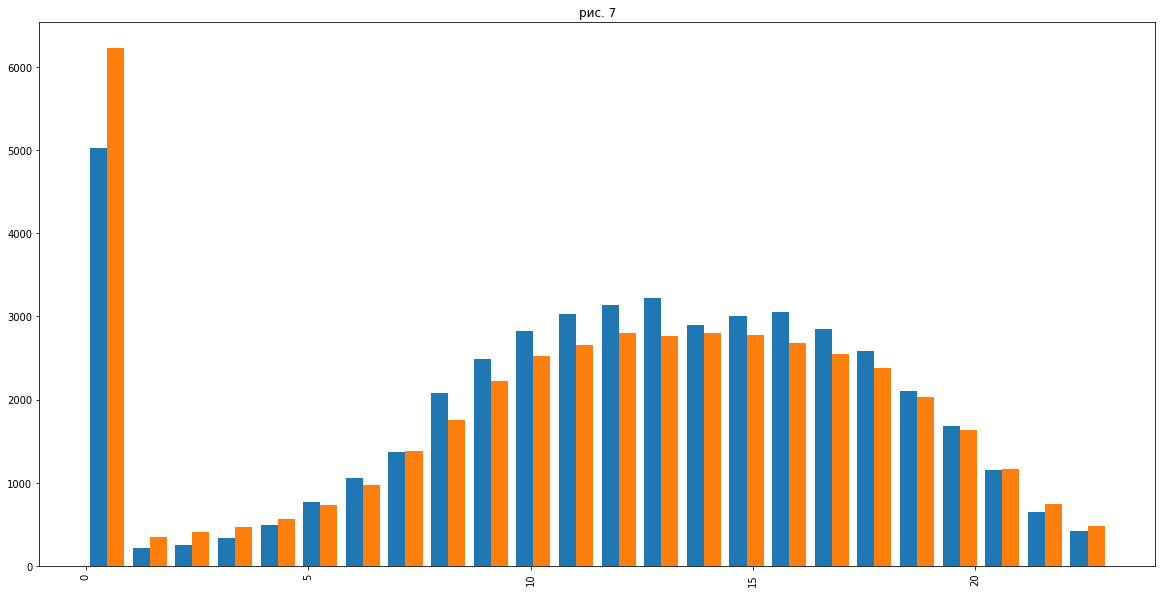

In [1117]:
plt.title('рис. 7')
vals = [data[1].time1.values for data in train.groupby(by='target')]
plt.xticks(rotation=90)
_, _, _ = plt.hist(vals, 24)

Видим, что в вечернее время одна из категорий производит больше транзакций, чем другая категория клиентов. Рассмотри, как соотносятся количество вечерних транзакций к количеству дневных транзакций в разрезе клиента.

In [1245]:
#Рассчитаем общее количество транзакций клиента в дневное и вечернее время соответственно
a = pd.concat([train[['client_id', 'target']], train.time1.apply(lambda x: 0 if x<5 or x>20 else 1)], axis=1).pivot_table(index='client_id', columns='time1', aggfunc='count').fillna(0)
#Рассчитаем отношение количества вечкрних транзакций к общему количесту 
ftime = a[('target', 0)] / a.sum(axis=1)
ftime.replace([np.inf, -np.inf], 1, inplace=True)
#Сруппируем данные по полу 
pd.concat([client_target, ftime.reset_index()], axis=1).drop(columns='client_id').groupby(by='target').describe().T

target             0            1
0 count  3340.000000  2660.000000
  mean      0.170489     0.207523
  std       0.197155     0.211208
  min       0.000000     0.000000
  25%       0.000000     0.000000
  50%       0.120606     0.166667
  75%       0.266667     0.333333
  max       1.000000     1.000000

In [1120]:
train['weekday'] = train.date1.apply(lambda x: x.weekday())

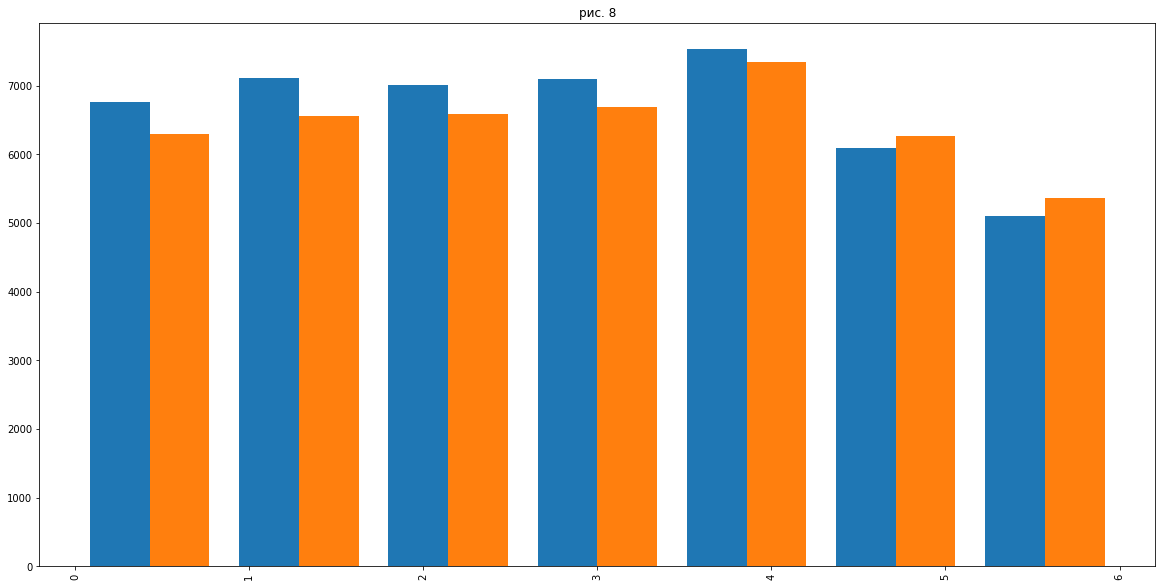

In [1128]:
plt.title('рис. 8')
vals = [data[1].weekday.values for data in train.groupby(by='target')]
plt.xticks(rotation=90)
_, _, _ = plt.hist(vals, 7)

На рис. 8 отображена зависимость распределения количества транзакций каждого пола от для недели проведения транзакции. Можем предположить, что на выходных активность одной категории выше, чем другой. Введем новую переменную - выходные, и рассмотри поведения клиентов на выходных и будних днях.

In [1123]:
import holidays 
train['weekend'] = train.date1.apply(pd.Timestamp.date).isin(holidays.Russia(years = 2017).keys()) | train.date1.apply(pd.Timestamp.date).isin(holidays.Russia(years = 2016).keys()) | train.weekday.isin([5,6])

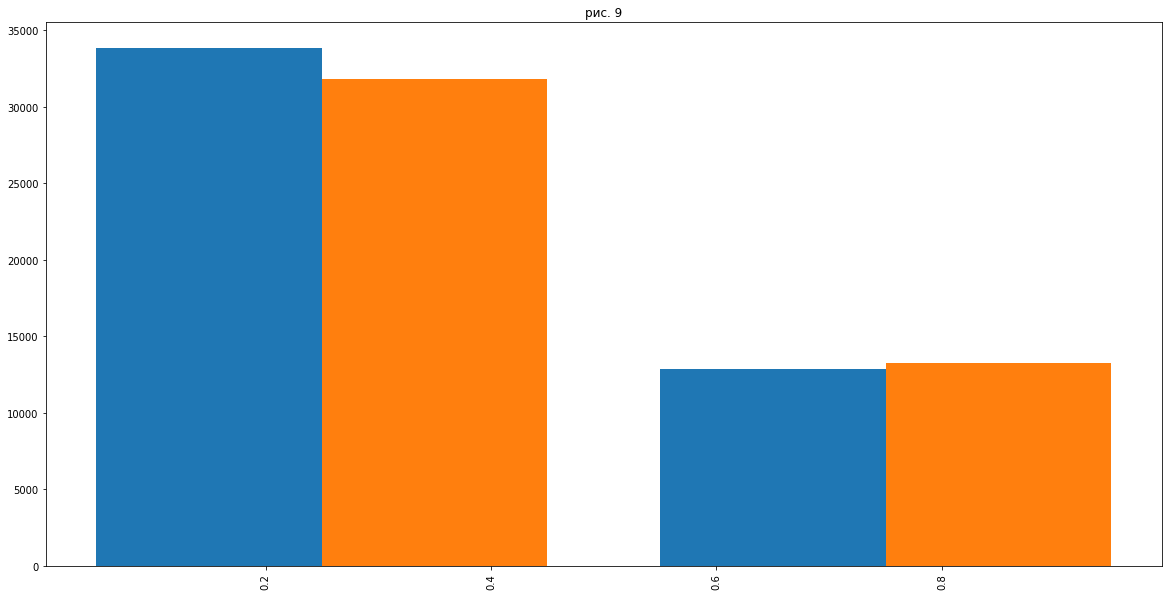

In [1129]:
plt.title('рис. 9')
vals = [data[1].weekend.values for data in train.groupby(by='target')]
plt.xticks(rotation=90)
_, _, _ = plt.hist(vals, 2)

In [1244]:
a = train[['client_id', 'target', 'weekend']].pivot_table(index='client_id', columns='weekend', aggfunc='count').fillna(0)
fweekend = a[('target', False)] / a.sum(axis=1)
fweekend.replace([np.inf, -np.inf], 1, inplace=True)
pd.concat([client_target, fweekend.reset_index()], axis=1).drop(columns='client_id').groupby(by='target').describe().T

target             0            1
0 count  3340.000000  2660.000000
  mean      0.721406     0.703925
  std       0.200626     0.195893
  min       0.000000     0.000000
  25%       0.625000     0.600000
  50%       0.733333     0.714286
  75%       0.846154     0.823529
  max       1.000000     1.000000

In [1126]:
def seasons(x):
    season = {
        1:'winter',
        2:'winter',
        3:'spring',
        4:'spring',
        5:'spring',
        6:'summer',
        7:'summer',
        8:'summer',
        9:'autumn',
        10:'autumn',
        11:'autumn',
        12:'winter'
    }
    return season[x.month]
train['season'] = train.date1.apply(seasons)

In [1127]:
train['month'] = train.date1.apply(lambda x: x.month)
train['year'] = train.date1.apply(lambda x: x.year)

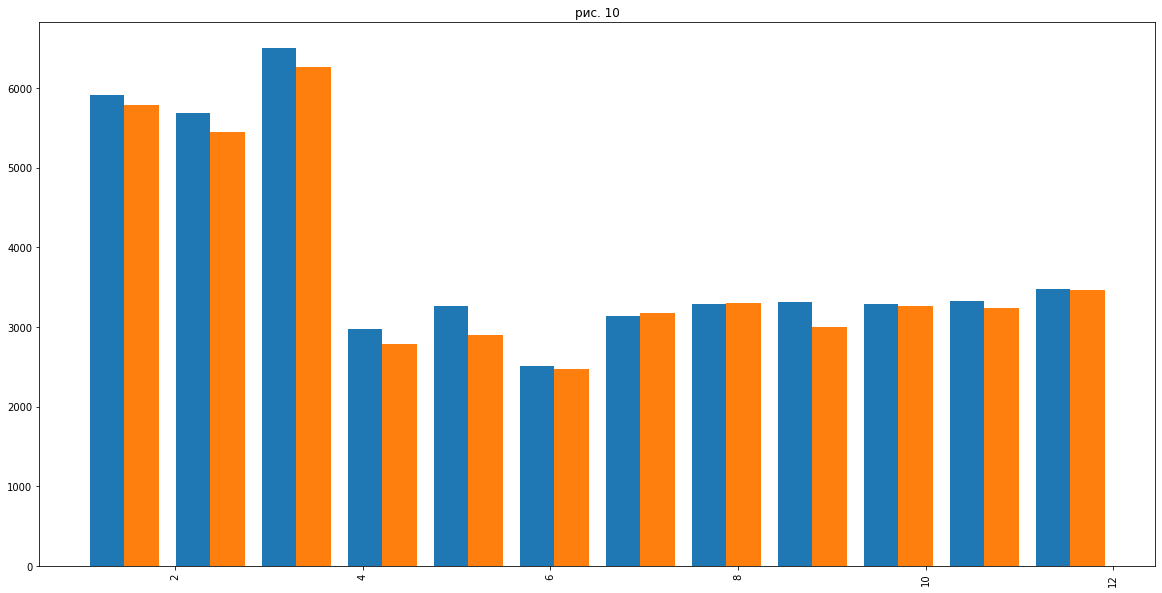

In [1130]:
plt.title('рис. 10')
vals = [data[1].month.values for data in train.groupby(by='target')]
plt.xticks(rotation=90)
_, _, _ = plt.hist(vals, 12)

На рис. 10 отображена зависимость распределения количества транзакций каждого пола от месяца совершения транзакции.

In [1243]:
a = train[['client_id', 'target', 'season']].pivot_table(index='client_id', columns='season', aggfunc='count').fillna(0)
fseasons = pd.concat([a[('target', 'autumn')] / a.sum(axis=1), \
               a[('target', 'spring')] / a.sum(axis=1),\
               a[('target', 'summer')] / a.sum(axis=1),\
               a[('target', 'winter')] / a.sum(axis=1)], axis=1).fillna(0).reset_index().merge(client_target, how='inner', left_on='client_id', right_on='client_id')
pd.set_option('display.max_rows', None)
fseasons.drop(columns='client_id').groupby(by='target').describe().T

target             0            1
0 count  3340.000000  2660.000000
  mean      0.211351     0.212016
  std       0.184131     0.181104
  min       0.000000     0.000000
  25%       0.090909     0.090909
  50%       0.198214     0.200000
  75%       0.300000     0.285714
  max       1.000000     1.000000
1 count  3340.000000  2660.000000
  mean      0.273049     0.263239
  std       0.199242     0.196025
  min       0.000000     0.000000
  25%       0.153846     0.142857
  50%       0.250000     0.250000
  75%       0.363636     0.348370
  max       1.000000     1.000000
2 count  3340.000000  2660.000000
  mean      0.184302     0.182821
  std       0.168814     0.166031
  min       0.000000     0.000000
  25%       0.000000     0.058824
  50%       0.166667     0.166667
  75%       0.266667     0.250000
  max       1.000000     1.000000
3 count  3340.000000  2660.000000
  mean      0.331299     0.341924
  std       0.213722     0.217850
  min       0.000000     0.000000
  25%       0.200000     0.214286
  50%       0.333333     0.333333
  75%       0.440000     0.440974
  max       1.000000     1.000000

На рис. 11 отображена годовая зависимость.

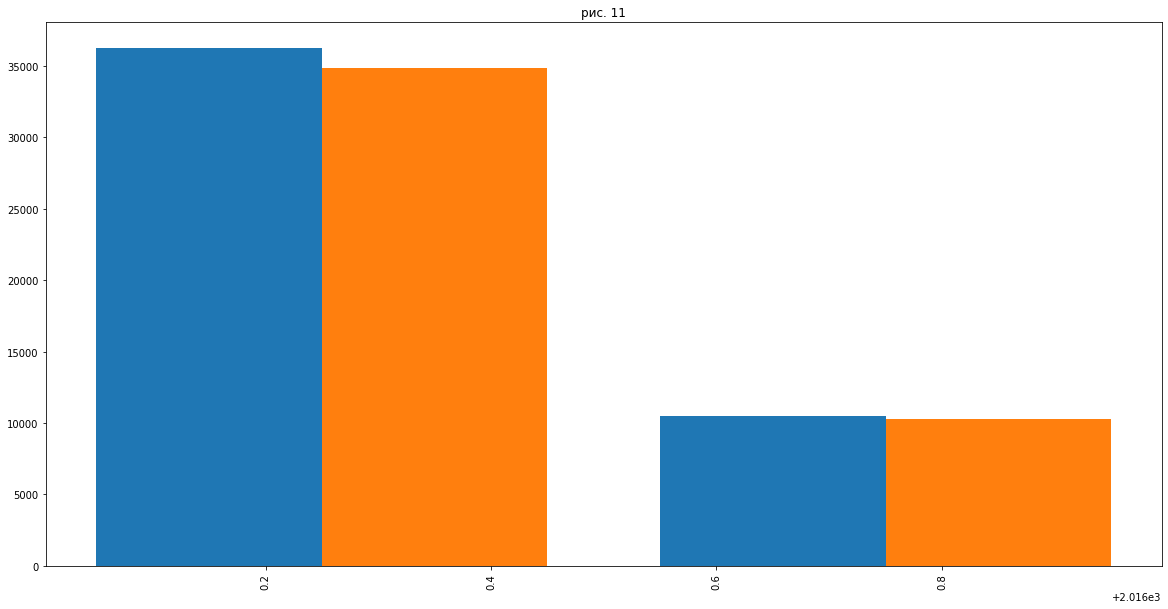

In [1131]:
plt.title('рис. 11')
vals = [data[1].year.values for data in train.groupby(by='target')]
plt.xticks(rotation=90)
_, _, _ = plt.hist(vals, 2)

In [1247]:
pd.set_option('display.max_rows', 10)

Можем сделать вывод о целесообразности введения новых признаков по данным временным зависимостям. 
Рассмотрим каждую из характеристик с позиции поступлений, расходов и общего числа транзакций

In [ ]:
c = train['sum']<0

In [237]:
#Рассчитаем среднее количество транзакций клиента в день недели
weekday_fcounts = train.groupby(by=['date1', 'client_id', 'weekday', 'target'])\
                 .count()\
                 .time1\
                 .groupby(by=['client_id', 'weekday', 'target'])\
                 .mean()\
                 .reset_index()\
                 .pivot_table(index=['client_id', 'target'], columns='weekday')\
                 .fillna(0)
#Рассчитаем медиану суммы трат в день недели
weekday_fexpenses = train[c].groupby(by=['date1', 'client_id', 'weekday'])\
                             .sum()\
                             ['sum']\
                             .groupby(by=['client_id', 'weekday'])\
                             .apply(lambda x: x.median())\
                             .reset_index()\
                             .pivot_table(index='client_id', columns='weekday')\
                             .fillna(0)
#Рассчитаем медиану суммы поступлений в день недели
weekday_freceipts = train[~c].groupby(by=['date1', 'client_id', 'weekday'])\
                             .sum()\
                             ['sum']\
                             .groupby(by=['client_id', 'weekday'])\
                             .apply(lambda x: x.median())\
                             .reset_index()\
                             .pivot_table(index='client_id', columns='weekday')\
                             .fillna(0)
weekday_f = weekday_fcounts.merge(weekday_fexpenses, how='outer', left_on='client_id', right_on='client_id')\
                           .merge(weekday_freceipts, how='outer', left_on='client_id', right_on='client_id')\
                           .fillna(0)
weekday_f

time1                                       sum_x             \
weekday       0     1    2    3    4     5    6           0          1   
client_id                                                                
22899      1.00  1.00  1.0  1.0  1.0  1.00  1.0   -4491.830  -4626.590   
27914      0.00  0.00  1.0  1.0  0.0  1.00  1.0       0.000      0.000   
28753      1.00  1.00  1.0  1.0  1.0  1.00  1.0  -39640.415  -4491.830   
38084      1.00  1.25  1.0  1.0  1.0  1.25  1.0  -44918.320 -17991.135   
49793      1.25  1.00  1.0  1.0  1.0  1.00  1.0   -2245.920  -3074.660   
...         ...   ...  ...  ...  ...   ...  ...         ...        ...   
99900908   1.00  0.00  0.0  1.0  1.0  0.00  0.0   -9270.470      0.000   
99911226   1.00  1.00  1.0  0.0  1.0  0.00  0.0  -13144.220 -22728.670   
99967537   1.00  0.00  0.0  0.0  0.0  0.00  0.0 -336887.370      0.000   
99985917   0.00  0.00  1.0  0.0  0.0  0.00  0.0       0.000      0.000   
99991245   0.00  1.00  1.5  0.0  0.0  0.00  0.0       0.000 -67377.470   

                       ...                                        sum_y  \
weekday             2  ...          4          5           6          0   
client_id              ...                                                
22899           0.000  ...   -7748.41      0.000       0.000       0.00   
27914           0.000  ...       0.00      0.000   -2245.920       0.00   
28753     -132509.030  ...  -18889.27  -4491.830 -120156.495       0.00   
38084       -2245.920  ...  -51308.62 -50543.435  -43478.120  202132.42   
49793       -3252.090  ...   -3546.30  -3992.565   -4839.950   11229.58   
...               ...  ...        ...        ...         ...        ...   
99900908        0.000  ...  -25034.89      0.000       0.000       0.00   
99911226   -43280.145  ... -112295.79      0.000       0.000       0.00   
99967537        0.000  ...       0.00      0.000       0.000       0.00   
99985917  -224591.580  ...       0.00      0.000       0.000       0.00   
99991245   -16574.860  ...       0.00      0.000       0.000       0.00   

                                                                           
weekday            1          2          3          4         5         6  
client_id                                                                  
22899           0.00   22459.16       0.00       0.00  44918.32  17967.33  
27914           0.00   11229.58       0.00       0.00  67377.47      0.00  
28753      673774.73       0.00       0.00       0.00      0.00      0.00  
38084      112295.79       0.00  505331.05  224591.58      0.00      0.00  
49793           0.00       0.00       0.00       0.00  15721.41      0.00  
...              ...        ...        ...        ...       ...       ...  
99900908        0.00       0.00       0.00       0.00      0.00      0.00  
99911226        0.00       0.00       0.00       0.00      0.00      0.00  
99967537        0.00       0.00       0.00       0.00      0.00      0.00  
99985917        0.00       0.00       0.00       0.00      0.00      0.00  
99991245        0.00  653561.49       0.00       0.00      0.00      0.00  

[6000 rows x 21 columns]

In [276]:
#Составим календарь недель для рассматриваемого промежутка времени
a = train[['date1', 'weekday']].drop_duplicates().sort_values(by='date1')
week = (((a.date1.iloc[0] - a.date1).abs() + pd.Timedelta(days = a.iloc[0].weekday)) / 7).apply(lambda x: x.days)
week = pd.DataFrame([week.values, a.date1.values]).T
week

,0,1
0,0,2016-01-01
1,0,2016-01-02
2,0,2016-01-03
3,1,2016-01-04
4,1,2016-01-05
...,...,...
452,65,2017-03-28
453,65,2017-03-29
454,65,2017-03-30
455,65,2017-03-31


In [292]:
train['week'] = train.date1.apply(lambda x: week[0][x == week[1]].iloc[0])

In [293]:
train

,client_id,target,datetime,code,type,sum,date,time1,time2,time3,time0,date1,datetime0,weekday,weekend,season,month,year,week
0,75063019,0,397 20:05:07,4814,1030,-4491.83,397,20,5,7,20:05:07,2017-02-01,2017-02-01 20:05:07,2,False,winter,2,2017,57
1,75063019,0,86 20:29:50,6010,7070,4491.83,86,20,29,50,20:29:50,2016-03-27,2016-03-27 20:29:50,6,True,spring,3,2016,12
2,75063019,0,375 16:00:33,4814,1030,-3144.28,375,16,0,33,16:00:33,2017-01-10,2017-01-10 16:00:33,1,False,winter,1,2017,54
3,75063019,0,136 17:10:60,5411,1010,-3930.35,136,17,11,0,17:11:00,2016-05-16,2016-05-16 17:11:00,0,False,spring,5,2016,20
4,75063019,0,378 13:01:51,6011,2010,-4491.83,378,13,1,51,13:01:51,2017-01-13,2017-01-13 13:01:51,4,False,winter,1,2017,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91821,1846496,0,452 00:00:00,5999,1100,-2243.45,452,0,0,0,00:00:00,2017-03-28,2017-03-28 00:00:00,1,False,spring,3,2017,65
91822,1846496,0,196 13:59:07,5411,1010,-4783.80,196,13,59,7,13:59:07,2016-07-15,2016-07-15 13:59:07,4,False,summer,7,2016,28
91823,1846496,0,186 13:38:15,5732,1010,-112273.33,186,13,38,15,13:38:15,2016-07-05,2016-07-05 13:38:15,1,False,summer,7,2016,27
91824,1846496,0,440 16:02:57,6010,7030,168443.68,440,16,2,57,16:02:57,2017-03-16,2017-03-16 16:02:57,3,False,spring,3,2017,63


In [303]:
#Рассчитаем среднее количество транзакций выходного для для клиента
weekend_fexpenses = train[c].groupby(by=['client_id', 'target', 'week', 'weekend'])\
                            .sum()\
                            ['sum']\
                            .groupby(by=['client_id', 'target', 'weekend'])\
                            .mean()\
                            .reset_index()\
                            .pivot_table(columns='weekend', index=['client_id', 'target'])\
                            .fillna(0)
#Оассчитаем среднюю сумму трат на выходных для клиента
weekend_freceipts = train[~c].groupby(by=['client_id', 'target', 'week', 'weekend'])\
                            .sum()\
                            ['sum']\
                            .groupby(by=['client_id', 'target', 'weekend'])\
                            .mean()\
                            .reset_index()\
                            .pivot_table(columns='weekend', index=['client_id', 'target'])\
                            .fillna(0)
#Рассчитем среднюю сумму поступлений
weekend_fcounts = train.groupby(by=['client_id', 'target', 'week', 'weekend'])\
                        .count()\
                        ['sum']\
                        .groupby(by=['client_id', 'target', 'weekend'])\
                        .mean()\
                        .reset_index()\
                        .pivot_table(columns='weekend', index=['client_id', 'target'])\
                        .fillna(0)
weekend_f = weekend_fcounts.merge(weekend_fexpenses, how='outer', left_on=['client_id', 'target'], right_on=['client_id', 'target'])\
                            .merge(weekend_freceipts, how='outer', left_on=['client_id', 'target'], right_on=['client_id', 'target'])\
                            .fillna(0)
weekend_f

sum_x                    sum_y                \
weekend              False     True           False         True    
client_id target                                                    
22899     1       1.000000  1.000000   -5749.545000      0.000000   
27914     1       1.000000  1.000000   -2245.920000  -2245.920000   
28753     0       1.000000  1.000000 -335418.911111 -81601.606667   
38084     0       1.117647  1.166667  -56447.898462 -54082.661667   
49793     1       1.153846  1.000000 -115671.776667  -4260.728000   
...                    ...       ...            ...           ...   
99900908  0       1.000000  0.000000  -14410.426000      0.000000   
99911226  0       1.090909  0.000000  -60689.993636      0.000000   
99967537  1       1.000000  0.000000 -336887.370000      0.000000   
99985917  0       1.000000  0.000000 -224591.580000      0.000000   
99991245  1       1.333333  0.000000  -41976.165000      0.000000   

                            sum             
weekend                   False      True   
client_id target                            
22899     1        22459.160000  31442.825  
27914     1        11229.580000  67377.470  
28753     0       673774.730000      0.000  
38084     0       291969.051667      0.000  
49793     1        11229.580000  15721.410  
...                         ...        ...  
99900908  0            0.000000      0.000  
99911226  0            0.000000      0.000  
99967537  1            0.000000      0.000  
99985917  0            0.000000      0.000  
99991245  1       653561.490000      0.000  

[6000 rows x 6 columns]

In [308]:
#Рассчмиаем среднюю сумму трат клиента за сезон
season_fexpenses = train[c].groupby(by=['client_id', 'target', 'year', 'season'])\
                            .sum()\
                            ['sum']\
                            .groupby(by=['client_id', 'target', 'season'])\
                            .mean()\
                            .reset_index()\
                            .pivot_table(columns='season', index=['client_id', 'target'])\
                            .fillna(0)
#Рассчитаем среднюю сумму поступлений для клиента за сезон
season_freceipts = train[~c].groupby(by=['client_id', 'target', 'year', 'season'])\
                            .sum()\
                            ['sum']\
                            .groupby(by=['client_id', 'target', 'season'])\
                            .mean()\
                            .reset_index()\
                            .pivot_table(columns='season', index=['client_id', 'target'])\
                            .fillna(0)
#Рассчитаем среднее количество транзакций клиента за сезон
season_fcounts = train.groupby(by=['client_id', 'target', 'year', 'season'])\
                        .count()\
                        ['sum']\
                        .groupby(by=['client_id', 'target', 'season'])\
                        .mean()\
                        .reset_index()\
                        .pivot_table(columns='season', index=['client_id', 'target'])\
                        .fillna(0)
season_f = season_fcounts.merge(season_fexpenses, how='outer', left_on=['client_id', 'target'], right_on=['client_id', 'target'])\
                            .merge(season_freceipts, how='outer', left_on=['client_id', 'target'], right_on=['client_id', 'target'])\
                            .fillna(0)
season_f

sum_x                           sum_y              \
season           autumn spring summer winter     autumn      spring   
client_id target                                                      
22899     1         0.0    1.5    3.0    3.0       0.00   -6625.450   
27914     1         2.0    1.0    1.0    0.0   -2245.92       0.000   
28753     0         2.0    3.0    2.0    1.5 -148230.44 -832466.085   
38084     0         5.0    4.5    6.0    3.0 -470350.68 -158125.725   
49793     1         4.0    3.5    5.0    2.5  -15410.36 -680810.070   
...                 ...    ...    ...    ...        ...         ...   
99900908  0         3.0    1.0    1.0    0.0  -24303.96  -44918.320   
99911226  0         3.0    3.5    0.0    2.0 -103042.61 -222313.325   
99967537  1         1.0    0.0    0.0    0.0 -336887.37       0.000   
99985917  0         0.0    1.0    0.0    0.0       0.00 -224591.580   
99991245  1         3.0    0.0    0.0    1.0  -16574.86       0.000   

                                                sum                        \
season                summer      winter     autumn     spring     summer   
client_id target                                                            
22899     1        -12487.30   -8759.070       0.00   22459.16       0.00   
27914     1         -2245.92       0.000   11229.58   67377.47       0.00   
28753     0      -1366639.75  -41886.330       0.00  673774.73       0.00   
38084     0       -163065.85  -54325.335  247050.74  988202.94  112295.79   
49793     1        -13958.59   -9187.935   15721.41       0.00   11229.58   
...                      ...         ...        ...        ...        ...   
99900908  0         -2829.85       0.000       0.00       0.00       0.00   
99911226  0             0.00 -119920.670       0.00       0.00       0.00   
99967537  1             0.00       0.000       0.00       0.00       0.00   
99985917  0             0.00       0.000       0.00       0.00       0.00   
99991245  1             0.00  -67377.470  653561.49       0.00       0.00   

                             
season               winter  
client_id target             
22899     1        62885.65  
27914     1            0.00  
28753     0            0.00  
38084     0       202132.42  
49793     1            0.00  
...                     ...  
99900908  0            0.00  
99911226  0            0.00  
99967537  1            0.00  
99985917  0            0.00  
99991245  1            0.00  

[6000 rows x 12 columns]

In [313]:
weekend_f.columns = [
    'count_ww',
    'count_w',
    'expenses_ww',
    'expenses_w',
    'receipts_ww',
    'receipts_w'
]
season_f.columns = [
    'autumn_counts',
    'spring_counts',
    'summer_counts',
    'winter_counts',
    'autumn_expenses',
    'spring_expenses',
    'summer_expenses',
    'winter_expenses',
    'autumn_receipts',
    'spring_receipts',
    'summer_receipts',
    'winter_receipts'
]
weekday_f.columns = [
    '0_counts',
    '1_counts',
    '2_counts',
    '3_counts',
    '4_counts',
    '5_counts',
    '6_counts',
    '0_expenses',
    '1_expenses',
    '2_expenses',
    '3_expenses',
    '4_expenses',
    '5_expenses',
    '6_expenses',
    '0_receipts',
    '1_receipts',
    '2_receipts',
    '3_receipts',
    '4_receipts',
    '5_receipts',
    '6_receipts'
]
time_f = weekend_f.merge(season_f, how='outer', left_on=['client_id', 'target'], right_on=['client_id', 'target'])\
                  .merge(weekday_f, how='outer', left_on=['client_id'], right_on=['client_id'])\
                  .fillna(0)\
                  .reset_index()
time_f

,client_id,count_ww,count_w,expenses_ww,expenses_w,receipts_ww,receipts_w,autumn_counts,spring_counts,summer_counts,...,4_expenses,5_expenses,6_expenses,0_receipts,1_receipts,2_receipts,3_receipts,4_receipts,5_receipts,6_receipts
0,22899,1.000000,1.000000,-5749.545000,0.000000,22459.160000,31442.825,0.0,1.5,3.0,...,-7748.41,0.000,0.000,0.00,0.00,22459.16,0.00,0.00,44918.32,17967.33
1,27914,1.000000,1.000000,-2245.920000,-2245.920000,11229.580000,67377.470,2.0,1.0,1.0,...,0.00,0.000,-2245.920,0.00,0.00,11229.58,0.00,0.00,67377.47,0.00
2,28753,1.000000,1.000000,-335418.911111,-81601.606667,673774.730000,0.000,2.0,3.0,2.0,...,-18889.27,-4491.830,-120156.495,0.00,673774.73,0.00,0.00,0.00,0.00,0.00
3,38084,1.117647,1.166667,-56447.898462,-54082.661667,291969.051667,0.000,5.0,4.5,6.0,...,-51308.62,-50543.435,-43478.120,202132.42,112295.79,0.00,505331.05,224591.58,0.00,0.00
4,49793,1.153846,1.000000,-115671.776667,-4260.728000,11229.580000,15721.410,4.0,3.5,5.0,...,-3546.30,-3992.565,-4839.950,11229.58,0.00,0.00,0.00,0.00,15721.41,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,99900908,1.000000,0.000000,-14410.426000,0.000000,0.000000,0.000,3.0,1.0,1.0,...,-25034.89,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5996,99911226,1.090909,0.000000,-60689.993636,0.000000,0.000000,0.000,3.0,3.5,0.0,...,-112295.79,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5997,99967537,1.000000,0.000000,-336887.370000,0.000000,0.000000,0.000,1.0,0.0,0.0,...,0.00,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5998,99985917,1.000000,0.000000,-224591.580000,0.000000,0.000000,0.000,0.0,1.0,0.0,...,0.00,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Обучим модель CatBoost только на числовых описаниях временных характеристик.

In [1250]:
ctime_f = time_f.merge(train[['client_id', 'target']].drop_duplicates(), how='outer', left_on='client_id', right_on='client_id')
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(ctime_f):
    dt = CatBoostClassifier(verbose=False)
    dt.fit(ctime_f.loc[train_i, ~ctime_f.columns.isin(['target', 'client_id'])], 
           ctime_f.loc[train_i, 'target'], verbose=False)
    target_pred = dt.predict(ctime_f.loc[test_i, ~ctime_f.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(ctime_f.loc[test_i, 'target'].values, target_pred)
    
    print(confusion_matrix(target_pred, ctime_f.loc[test_i, 'target'].values))
    
    res = res.append({
            'accuracy': accuracy_score(target_pred, ctime_f.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, ctime_f.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, ctime_f.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
res 

[[493 369]
 [168 170]]
[[529 357]
 [143 171]]
[[521 297]
 [183 199]]
[[504 365]
 [142 189]]
[[519 345]
 [138 198]]


,accuracy,recall,f1,auc
0,0.552500,0.537442,0.517546,0.530619
1,0.583333,0.570826,0.542626,0.555533
2,0.600000,0.578931,0.568964,0.570633
3,0.577500,0.575487,0.546233,0.560670
4,0.597500,0.594990,0.566479,0.577298


In [1251]:
res.mean(), res.std()

(accuracy    0.582167
 recall      0.571535
 f1          0.548369
 auc         0.558951
 dtype: float64,
 accuracy    0.019081
 recall      0.021114
 f1          0.020855
 auc         0.017961
 dtype: float64)

Временные характеристики не дают такой же эффективности, как характеристики, использующиеся раннее, хотя и не похожт на полностью случайный процесс. Рассмотрим возможность использования и временных характеристик клиентов, и их количественное описание.

In [1252]:
train_time = train_tf_idf.merge(time_f, how='outer', left_on=['client_id'], right_on=['client_id'])

In [1253]:
train_time

,client_id,target,code_742,code_1711,code_1799,code_3000,code_3351,code_3501,code_4111,code_4112,...,4_expenses,5_expenses,6_expenses,0_receipts,1_receipts,2_receipts,3_receipts,4_receipts,5_receipts,6_receipts
0,22899,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7748.41,0.000,0.000,0.00,0.00,22459.16,0.00,0.00,44918.32,17967.33
1,27914,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000,-2245.920,0.00,0.00,11229.58,0.00,0.00,67377.47,0.00
2,28753,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-18889.27,-4491.830,-120156.495,0.00,673774.73,0.00,0.00,0.00,0.00,0.00
3,38084,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-51308.62,-50543.435,-43478.120,202132.42,112295.79,0.00,505331.05,224591.58,0.00,0.00
4,49793,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3546.30,-3992.565,-4839.950,11229.58,0.00,0.00,0.00,0.00,15721.41,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,99900908,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-25034.89,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5996,99911226,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-112295.79,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5997,99967537,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5998,99985917,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [1257]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(train_time):
    dt = CatBoostClassifier()
    dt.fit(train_time.loc[train_i, ~train_time.columns.isin(['target', 'client_id'])], 
           train_time.loc[train_i, 'target'], verbose=False)
    target_pred = dt.predict(train_time.loc[test_i, ~train_time.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(ctime_f.loc[test_i, 'target'].values, target_pred)
    print(confusion_matrix(target_pred, train_time.loc[test_i, 'target'].values))
    
    res = res.append({
            'accuracy': accuracy_score(target_pred, train_time.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, train_time.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, train_time.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[523 277]
 [121 279]]
[[575 235]
 [134 256]]
[[558 241]
 [128 273]]
[[539 270]
 [111 280]]
[[520 272]
 [131 277]]


,accuracy,recall,f1,auc
0,0.668333,0.675625,0.654029,0.656955
1,0.692500,0.683143,0.669117,0.666193
2,0.692500,0.689585,0.674118,0.672270
3,0.682500,0.691184,0.666987,0.669161
4,0.664167,0.667744,0.649807,0.651662


In [1258]:
res.mean(), res.std()

(accuracy    0.680000
 recall      0.681456
 f1          0.662812
 auc         0.663248
 dtype: float64,
 accuracy    0.013281
 recall      0.009818
 f1          0.010384
 auc         0.008644
 dtype: float64)

## "Экспертное мнение"

Оставим в выборке транзакции, соответствующие покупкам по типу (1010, 1110, 1100, 1200)

![title](12.png)

и транзакции, соответсвующие категориям, начиная с первой самой наполненной не общей (которую можно было бы отнести к какому-то полу) категории (6011, 6010, 4814, 5411, 4829, 5499, 5912, 5541, 5331, 5814, 5999, 5921, 5311).

![title](13.png)

In [1239]:
#ОТберем только те транзакции, которые определены интересующими нас категориями\типами
try_ = train[train.type.isin([1010, 
                                1110,
                                1100,
                                1200
                               ]) &
            ~train.code.isin([
                6011,
                6010,
                4814,
                5411,
                4829,
                5499,
                5912,
                5541,
                5331,
                5814,
                5999,
                5921,
                5311
            ])]
try_

,client_id,target,datetime,code,type,sum,date,time1,time2,time3,time0,date1,datetime0,weekday,weekend,season,month,year
17,75063019,0,329 22:22:49,5983,1010,-7854.64,329,22,22,49,22:22:49,2016-11-25,2016-11-25 22:22:49,4,False,autumn,11,2016
46,86227647,1,91 11:00:19,5812,1010,-26727.30,91,11,0,19,11:00:19,2016-04-01,2016-04-01 11:00:19,4,False,spring,4,2016
116,95213230,0,302 00:00:00,5812,1110,-4042.65,302,0,0,0,00:00:00,2016-10-29,2016-10-29 00:00:00,5,True,autumn,10,2016
121,95213230,0,439 00:00:00,8220,1100,-4845.79,439,0,0,0,00:00:00,2017-03-15,2017-03-15 00:00:00,2,False,spring,3,2017
123,95213230,0,184 00:00:00,5812,1110,-12801.72,184,0,0,0,00:00:00,2016-07-03,2016-07-03 00:00:00,6,True,summer,7,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91803,73504380,1,328 16:37:13,5211,1010,-7359.87,328,16,37,13,16:37:13,2016-11-24,2016-11-24 16:37:13,3,False,autumn,11,2016
91815,73504380,1,350 14:06:10,5211,1010,-254839.57,350,14,6,10,14:06:10,2016-12-16,2016-12-16 14:06:10,4,False,winter,12,2016
91816,1846496,0,228 13:43:45,5732,1010,-13336.70,228,13,43,45,13:43:45,2016-08-16,2016-08-16 13:43:45,1,False,summer,8,2016
91819,1846496,0,233 00:00:00,5211,1110,-1122.96,233,0,0,0,00:00:00,2016-08-21,2016-08-21 00:00:00,6,True,summer,8,2016


Рассчитаем для урезанной выборки tf-idf метрики.

In [1282]:
#Для категорий
a = try_.pivot_table(columns='code', index='client_id').target.fillna(0)
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(a)
code_ = pd.DataFrame(tfidf.toarray(), columns=a.columns)
code_ = pd.concat([code_, pd.Series(a.index)], axis=1)
code_

C:\Users\denet\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1466: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


,742,1711,1799,3000,3351,3501,4111,4112,4121,4131,...,8299,8398,8641,8699,8999,9222,9311,9399,9402,client_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22899
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28753
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38084
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81626
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99785861
3185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99834424
3186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99876778
3187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99900908


In [1283]:
#Для типов
a = try_.pivot_table(columns='type', index='client_id').target.fillna(0)
tfidf = transformer.fit_transform(a)
type_ = pd.DataFrame(tfidf.toarray(), columns=a.columns)
type_ = pd.concat([type_, pd.Series(a.index)], axis=1)
type_

,1010,1100,1110,1200,client_id
0,0.0,0.0,1.0,0.0,22899
1,0.0,0.0,0.0,0.0,28753
2,0.0,0.0,0.0,0.0,38084
3,0.0,0.0,0.0,0.0,81626
4,1.0,0.0,0.0,0.0,126081
...,...,...,...,...,...
3184,0.0,0.0,0.0,0.0,99785861
3185,0.0,0.0,0.0,0.0,99834424
3186,0.0,0.0,0.0,0.0,99876778
3187,0.0,0.0,0.0,0.0,99900908


Используем для моделирования tf-idf метрики из урезанной выборки, а также временные характеристики.

In [1284]:
try_ = code_.merge(type_, how='outer', left_on = 'client_id', right_on = 'client_id')\
     .merge(train_time[train_time.columns[[0,1]+list(range(344,390))]], how='outer', left_on = 'client_id', right_on = 'client_id')\
     .fillna(0)
try_

,742,1711,1799,3000,3351,3501,4111,4112,4121,4131,...,5_expenses,6_expenses,0_receipts,1_receipts,2_receipts,3_receipts,4_receipts,5_receipts,6_receipts,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.00,22459.16,0.00,0.00,44918.32,17967.33,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4491.830,-120156.495,0.00,673774.73,0.00,0.00,0.00,0.00,0.00,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-50543.435,-43478.120,202132.42,112295.79,0.00,505331.05,224591.58,0.00,0.00,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,-8548.630,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-31442.820,-22369.320,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-222345.660,0.000,0.00,0.00,0.00,0.00,73351.61,224591.58,0.00,1.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,-44918.320,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


In [964]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(try_):
    dt = CatBoostClassifier(verbose=False)
    dt.fit(try_.loc[train_i, ~try_.columns.isin(['target', 'client_id'])], 
           try_.loc[train_i, 'target'])
    target_pred = dt.predict(try_.loc[test_i, ~try_.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(try_.loc[test_i, 'target'].values, target_pred)
    
    print(confusion_matrix(target_pred, try_.loc[test_i, 'target'].values))
    
    res = res.append({
            'accuracy': accuracy_score(target_pred, try_.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'),
            'auc':auc(fpr, tpr)
        }, ignore_index=True)
    
res


[[617 188]
 [ 34 361]]
[[643 193]
 [ 36 328]]
[[639 196]
 [ 41 324]]
[[634 225]
 [ 35 306]]
[[633 221]
 [ 28 318]]


,accuracy,recall,f1,auc
0,0.815000,0.840192,0.806179,0.802666
1,0.809167,0.835119,0.795044,0.788270
2,0.802500,0.826470,0.787884,0.781391
3,0.783333,0.817714,0.765839,0.761977
4,0.792500,0.830146,0.777144,0.773811


In [965]:
res.mean(), res.std()

(accuracy    0.800500
 recall      0.829928
 f1          0.786418
 auc         0.781623
 dtype: float64,
 accuracy    0.012728
 recall      0.008566
 f1          0.015625
 auc         0.015281
 dtype: float64)

В урезанной по категориям и типам бд остается только 3189 клиента. Остальные клиенты описываются только временными характеристиками. Временные характеристики "справляются" с классификацикй не слишком эффективно. Таким образом, почти половина клиентов классифицируется слабо. Для того, чтобы "увеличить" эффективность на данных клиентах добавим информацию tf-idf метрик на всех категориях.

In [1290]:
code_.columns = ['codes_'+str(i) for i in range(len(code_.columns)-1)]+['client_id']
type_.columns = ['types_'+str(i) for i in range(len(type_.columns)-1)]+['client_id']
try_ = code_.merge(type_, how='outer', left_on = 'client_id', right_on = 'client_id')
try_ = try_.merge(train_time, how='outer', left_on = 'client_id', right_on = 'client_id')\
           .fillna(0)
try_

,codes_0,codes_1,codes_2,codes_3,codes_4,codes_5,codes_6,codes_7,codes_8,codes_9,...,5_expenses,6_expenses,0_receipts,1_receipts,2_receipts,3_receipts,4_receipts,5_receipts,6_receipts,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.00,22459.16,0.00,0.00,44918.32,17967.33,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4491.830,-120156.495,0.00,673774.73,0.00,0.00,0.00,0.00,0.00,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-50543.435,-43478.120,202132.42,112295.79,0.00,505331.05,224591.58,0.00,0.00,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,-8548.630,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-31442.820,-22369.320,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-222345.660,0.000,0.00,0.00,0.00,0.00,73351.61,224591.58,0.00,1.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,-44918.320,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


In [1291]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(try_):
    dt = CatBoostClassifier(verbose=False)
    dt.fit(try_.loc[train_i, ~try_.columns.isin(['target', 'client_id'])], 
           try_.loc[train_i, 'target'])
    target_pred = dt.predict(try_.loc[test_i, ~try_.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(try_.loc[test_i, 'target'].values, target_pred)
    
    print(confusion_matrix(target_pred, try_.loc[test_i, 'target'].values))
    
    res = res.append({
            'accuracy': accuracy_score(target_pred, try_.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'),
            'auc':auc(fpr, tpr)
        }, ignore_index=True)
    
res


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

[[615 186]
 [ 40 359]]
[[638 170]
 [ 52 340]]
[[613 190]
 [ 37 360]]
[[640 185]
 [ 41 334]]
[[616 170]
 [ 48 366]]


,accuracy,recall,f1,auc
0,0.811667,0.833770,0.802687,0.798823
1,0.815000,0.828475,0.802841,0.795652
2,0.810833,0.835094,0.802034,0.798811
3,0.811667,0.833212,0.798569,0.791670
4,0.818333,0.833886,0.810091,0.805273


In [1292]:
res.mean(), res.std()

(accuracy    0.813500
 recall      0.832888
 f1          0.803244
 auc         0.798046
 dtype: float64,
 accuracy    0.003140
 recall      0.002560
 f1          0.004203
 auc         0.004995
 dtype: float64)

# Подбор параметров модели

Попробуем улучшить эффективность модели настройкой гиперпараметров. Для поиска оптимальных величин гиперпараметров модели воспользуемся алгоритмом **дифференциальной эфолюции**. В качестве искомого ответа будем возвращать значение auc метрики для модели.

### Decision Tree

In [1293]:
def f(x):
    #Определим словарь значений искомых гиперпараметров
    p = {
        'max_depth': int(x[0]),
        'max_leaf_nodes': None if int(x[1])<=1 else int(x[1])
    }
    
    kf = KFold()
    res = []
    #Разделим выборку на 5 частей
    for train_i, test_i in kf.split(try_):
        #Определим модель с выбранными гиперпараметрами
        dt = DecisionTreeClassifier(**p)
        #Если значения гиперпараметров не протеворечят друг другу, обучаем модель, иначе возвращаем "худую" эффективность - 1. 
        try:
            dt.fit(try_.loc[train_i, ~try_.columns.isin(['target', 'client_id'])], 
                   try_.loc[train_i, 'target'])
        except Exception:
            return 1
        #Рассчитываем значение эффективности модели(точнее ее ошибку, так как задача нахождения минимума)
        target_pred = dt.predict(try_.loc[test_i, ~try_.columns.isin(['target', 'client_id'])])
        fpr, tpr, thresholds = roc_curve(try_.loc[test_i, 'target'].values, target_pred)

        res.append(1-auc(fpr, tpr))
    
    return np.mean(res)

    

In [1295]:
from scipy.optimize import differential_evolution
#Устанавливаем границы поиска значений гиперпарасетров
bounds = [
    
    (1,20),
    (1,20)
    
]
#Решаем оптимизационную задачу
result = differential_evolution(f, bounds, maxiter=20)
result.x, result.fun

(array([ 8.36013949, 13.75220516]), 0.2304224415694634)

In [1296]:
kf = KFold()
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(try_):
    dt = DecisionTreeClassifier(max_depth=8, max_leaf_nodes = 13)
    dt.fit(try_.loc[train_i, ~try_.columns.isin(['target', 'client_id'])], 
           try_.loc[train_i, 'target'])
    target_pred = dt.predict(try_.loc[test_i, ~try_.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(try_.loc[test_i, 'target'].values, target_pred)
    
    print(confusion_matrix(target_pred, try_.loc[test_i, 'target'].values))
    
    res = res.append({
            'accuracy': accuracy_score(target_pred, try_.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[613   3]
 [ 21 563]]
[[627   2]
 [ 19 552]]
[[626 157]
 [ 30 387]]
[[690 442]
 [ 30  38]]
[[639 449]
 [ 45  67]]


,accuracy,recall,f1,auc
0,0.980000,0.979585,0.979965,0.980788
1,0.982500,0.981773,0.982431,0.983489
2,0.844167,0.863773,0.837730,0.832833
3,0.606667,0.584182,0.441913,0.518750
4,0.588333,0.592765,0.467297,0.532028


In [1297]:
res.mean(), res.std()

(accuracy    0.800333
 recall      0.800416
 f1          0.741867
 auc         0.769578
 dtype: float64,
 accuracy    0.193544
 recall      0.199300
 f1          0.268846
 auc         0.231146
 dtype: float64)

### Bagging

In [1302]:
def f(x):
    p = {
        #'criterion': 'gini' if x[0]<0.5 else 'entropy',
        #'splitter': 'best' if x[1]<0.5 else 'random',
        'max_depth': int(x[0]),
        'max_leaf_nodes': None if int(x[1])<=1 else int(x[1])
    }
    pp = {
        'n_estimators': int(x[2]),
        'max_samples': x[3] if x[3]<1 else int(x[3]),
        'max_features': x[4] if x[4]<1 else int(x[4])
    }
    
    kf = KFold()
    res = []
    for train_i, test_i in kf.split(try_):
        dt = DecisionTreeClassifier(**p)
        bc = BaggingClassifier(base_estimator=dt,**pp)
        try:
            bc.fit(try_.loc[train_i, ~try_.columns.isin(['target', 'client_id'])], 
                   try_.loc[train_i, 'target'])
        except Exception:
            return 1
        target_pred = bc.predict(try_.loc[test_i, ~try_.columns.isin(['target', 'client_id'])])
        fpr, tpr, thresholds = roc_curve(try_.loc[test_i, 'target'].values, target_pred)

        res.append(1-auc(fpr, tpr))
    
    return np.mean(res)

In [1303]:
bounds = [
    
    (1,20),
    (1,20),
    (1,10),
    (0,4800),
    (0, 348)
    
]


result = differential_evolution(f, bounds, maxiter=1, popsize=5)
result.x, result.fun

(array([   6.81605364,    6.17445467,    3.7690568 , 2711.16955782,
         265.86346481]),
 0.23024966509715314)

In [1315]:
kf = KFold(shuffle=True)
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(train_tf_idf):
    dt = DecisionTreeClassifier(**{'max_depth': 6, 'max_leaf_nodes': 6})
    bc = BaggingClassifier(base_estimator=dt, **{'n_estimators': 3, 'max_samples': 2711, 'max_features': 265})
    bc.fit(try_.loc[train_i, ~try_.columns.isin(['target', 'client_id'])], 
           try_.loc[train_i, 'target'])
    target_pred = bc.predict(try_.loc[test_i, ~try_.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(try_.loc[test_i, 'target'].values, target_pred)
    print(confusion_matrix(target_pred, try_.loc[test_i, 'target'].values))
    
    res = res.append({
            'accuracy': accuracy_score(target_pred, try_.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[637 261]
 [ 27 275]]
[[659 287]
 [  0 254]]
[[685 220]
 [ 10 285]]
[[655 244]
 [  1 300]]
[[666 237]
 [  0 297]]


,accuracy,recall,f1,auc
0,0.760000,0.809975,0.735973,0.736199
1,0.760833,0.848309,0.730089,0.734750
2,0.808333,0.861504,0.784375,0.774984
3,0.795833,0.862633,0.776251,0.774973
4,0.802500,0.868771,0.781875,0.778090


In [1316]:
res.mean(), res.std()

(accuracy    0.785500
 recall      0.850238
 f1          0.761713
 auc         0.759799
 dtype: float64,
 accuracy    0.023323
 recall      0.023711
 f1          0.026430
 auc         0.022247
 dtype: float64)

### CatBoost

Жадный поиск

In [1319]:
from sklearn.model_selection import GridSearchCV
parameters = {
        'iterations': [950,1500],
        'learning_rate': (0,1),
        'depth': [4,10]
    }
clf = GridSearchCV(CatBoostClassifier(verbose=False), parameters)
clf.fit(try_.loc[train_i, ~try_.columns.isin(['target', 'client_id'])], 
        try_.loc[train_i, 'target'])
clf.best_params_

C:\Users\denet\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/boosting_options.cpp:79: Learning rate should be non-zero

  FitFailedWarning)
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

{'depth': 4, 'iterations': 1500, 'learning_rate': 1}

In [1322]:
kf = KFold()
res = pd.DataFrame([], columns=['accuracy', 'recall', 'f1', 'auc'])
for train_i, test_i in kf.split(try_):
    cat = CatBoostClassifier(iterations=1500, learning_rate=1, depth=4)
    cat.fit(try_.loc[train_i, ~try_.columns.isin(['target', 'client_id'])], 
            try_.loc[train_i, 'target'],
            verbose=False, plot=False)

    target_pred = cat.predict(try_.loc[test_i, ~try_.columns.isin(['target', 'client_id'])])
    fpr, tpr, thresholds = roc_curve(try_.loc[test_i, 'target'].values, target_pred)
    print(confusion_matrix(target_pred, try_.loc[test_i, 'target'].values))

    res = res.append({
            'accuracy': accuracy_score(target_pred, try_.loc[test_i, 'target'].values), 
            'recall': recall_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'), 
            'f1': f1_score(target_pred, try_.loc[test_i, 'target'].values, average='macro'),
            'auc': auc(fpr, tpr)
        }, ignore_index=True)
    
res

[[613   1]
 [ 21 565]]
[[625   8]
 [ 21 546]]
[[577 119]
 [ 79 425]]
[[510 297]
 [210 183]]
[[510 337]
 [174 179]]


,accuracy,recall,f1,auc
0,0.981667,0.981268,0.981637,0.982555
1,0.975833,0.975162,0.975728,0.976526
2,0.835000,0.836138,0.832309,0.830412
3,0.577500,0.548810,0.543610,0.544792
4,0.574167,0.554604,0.539100,0.546257


In [1323]:
res.mean(), res.std()

(accuracy    0.788833
 recall      0.779196
 f1          0.774477
 auc         0.776108
 dtype: float64,
 accuracy    0.203119
 recall      0.215637
 f1          0.221057
 auc         0.219132
 dtype: float64)

## Сравнение моделей

Для определения модели с "лучшей" эффективностью воспользуемся инструментами сравнения результатов моделирования. Проведем статистическую проверку гипотезы о равенстве стредних различных метрик оценки моделей. 

Проверим, отличаются ли признаки для эффективности модели. Используем оценку по статистике t-теста Стюдента для проверки принаддежности средних эффективности модели на разнвх характеристиках к одному распределению.

In [1377]:
def ttest(features1, label1, features2, label2, model):
    #Разделим выборку на 10 частей
    kf = KFold(n_splits=10, shuffle=True)

    auc1 = []
    #Обучим модель на первом наборе признаков
    for train, test in kf.split(features1):
        model.fit(features1.loc[train], label1.loc[train])
        target_pred = model.predict(features1.loc[test])
        fpr, tpr, thresholds = roc_curve(label1.loc[test].values, target_pred)
        #В качестве меры сравнения возмем метрику auc
        auc1.append(auc(fpr, tpr))

    auc2=[]
    #Обучим модель на втором наборе признаков
    for train, test in kf.split(features2):
        model.fit(features2.loc[train], label2.loc[train])
        target_pred = model.predict(features2.loc[test])
        fpr, tpr, thresholds = roc_curve(label2.loc[test].values, target_pred)
        auc2.append(auc(fpr, tpr))

    #Сравним полученные значения, рассчитав статистику t-Стьюдента и взяв за основу сравнения p занчение
    return ttest_ind(auc1, auc2).pvalue

In [1378]:
"""tt = [
    ttest(train_word2vec.drop(columns=['client_id', 'target']), train_word2vec.target, 
          train_tf_idf.drop(columns=['client_id', 'target']), train_tf_idf.target,
          CatBoostClassifier(verbose=False)),
    ttest(train_word2vec.drop(columns=['client_id', 'target']), train_word2vec.target, 
          train_time.drop(columns=['client_id', 'target']), train_time.target,
          CatBoostClassifier(verbose=False)),
    ttest(train_word2vec.drop(columns=['client_id', 'target']), train_word2vec.target, 
          try_.drop(columns=['client_id', 'target']), try_.target,
          CatBoostClassifier(verbose=False)),
    ttest(train_tf_idf.drop(columns=['client_id', 'target']), train_tf_idf.target, 
          train_time.drop(columns=['client_id', 'target']), train_time.target,
          CatBoostClassifier(verbose=False)),
    ttest(train_tf_idf.drop(columns=['client_id', 'target']), train_tf_idf.target, 
          try_.drop(columns=['client_id', 'target']), try_.target,
          CatBoostClassifier(verbose=False)),
    ttest(train_time.drop(columns=['client_id', 'target']), train_time.target, 
          try_.drop(columns=['client_id', 'target']), try_.target,
          CatBoostClassifier(verbose=False))
]"""

tt = [
    ttest(train_word2vec.drop(columns=['client_id', 'target']), train_word2vec.target, 
          train_tf_idf.drop(columns=['client_id', 'target']), train_tf_idf.target,
          DecisionTreeClassifier()),
    ttest(train_word2vec.drop(columns=['client_id', 'target']), train_word2vec.target, 
          train_time.drop(columns=['client_id', 'target']), train_time.target,
          DecisionTreeClassifier()),
    ttest(train_word2vec.drop(columns=['client_id', 'target']), train_word2vec.target, 
          try_.drop(columns=['client_id', 'target']), try_.target,
          DecisionTreeClassifier()),
    ttest(train_tf_idf.drop(columns=['client_id', 'target']), train_tf_idf.target, 
          train_time.drop(columns=['client_id', 'target']), train_time.target,
          DecisionTreeClassifier()),
    ttest(train_tf_idf.drop(columns=['client_id', 'target']), train_tf_idf.target, 
          try_.drop(columns=['client_id', 'target']), try_.target,
          DecisionTreeClassifier()),
    ttest(train_time.drop(columns=['client_id', 'target']), train_time.target, 
          try_.drop(columns=['client_id', 'target']), try_.target,
          DecisionTreeClassifier())
]

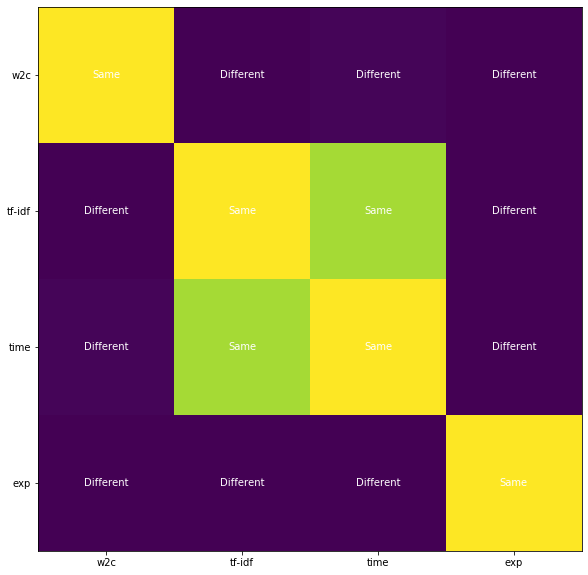

In [1376]:
harvest = [[1, tt[0], tt[1], tt[2]],
            [tt[0], 1, tt[3], tt[4]],
            [tt[1], tt[3], 1, tt[5]],
            [tt[2], tt[4], tt[5], 1]]

fig, ax = plt.subplots()
im = ax.imshow(np.array(harvest))

ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels(['w2c', 'tf-idf', 'time', 'exp'])
ax.set_yticklabels(['w2c', 'tf-idf', 'time', 'exp'])

for i in range(len(harvest)):
    for j in range(len(harvest[0])):
        text = ax.text(j, i, 'Same' if harvest[i][j]>0.05 else 'Different',
                       ha="center", va="center", color="w")

Проверим, отличаются ли статистически модели друг от друга на одних и тех же признаках. Проверку проведем при помощи статистики Мак-Немара.

In [1353]:
def mcnemar_comparison(model1, model2, model3, X, y):
    #Оазделим выборку на тренировочную и тестовую части
    train_x, test_x, train_l, test_l = train_test_split(X, y)
        
    #Обучим три интересующие модели    
    model1.fit(train_x, train_l)
    model2.fit(train_x, train_l)
    model3.fit(train_x, train_l)

    target_pred1 = model1.predict(test_x)
    target_pred2 = model2.predict(test_x)
    target_pred3 = model2.predict(test_x)
    
    target_pred1==test_l
        
    #Определим результирующую таблицу для каждого возможного варианта сравнения моделей
    table12 = [[sum((target_pred1==test_l)&(target_pred2==test_l)), sum((target_pred1==test_l)&(target_pred2!=test_l))],
               [sum((target_pred1!=test_l)&(target_pred2==test_l)), sum((target_pred1!=test_l)&(target_pred2!=test_l))]]
    
    table13 = [[sum((target_pred1==test_l)&(target_pred3==test_l)), sum((target_pred1==test_l)&(target_pred3!=test_l))],
               [sum((target_pred1!=test_l)&(target_pred3==test_l)), sum((target_pred1!=test_l)&(target_pred3!=test_l))]]

    table23 = [[sum((target_pred2==test_l)&(target_pred3==test_l)), sum((target_pred2==test_l)&(target_pred3!=test_l))],
               [sum((target_pred2!=test_l)&(target_pred3==test_l)), sum((target_pred2!=test_l)&(target_pred3!=test_l))]]
    
    result12 = mcnemar(table12, exact=True)
    result13 = mcnemar(table13, exact=True)
    result23 = mcnemar(table23, exact=True)
       
    #Возьмем за основу сравнения p занчение
    return [[1, result12.pvalue, result13.pvalue],
            [result12.pvalue, 1, result23.pvalue],
            [result13.pvalue, result23.pvalue, 1]]

In [1354]:
harvest = mcnemar_comparison(CatBoostClassifier(verbose=False), 
                             DecisionTreeClassifier(),
                             BaggingClassifier(base_estimator=DecisionTreeClassifier()),
                             try_.drop(columns=['client_id', 'target']),
                             try_.target)
harvest

[[1, 1.395320418165309e-06, 1.395320418165309e-06],
 [1.395320418165309e-06, 1, 1.0],
 [1.395320418165309e-06, 1.0, 1]]

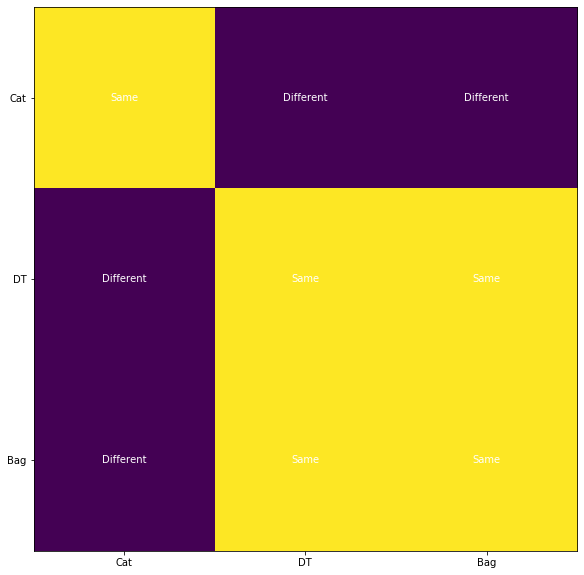

In [1355]:
fig, ax = plt.subplots()
im = ax.imshow(np.array(harvest))


ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(['Cat', 'DT', 'Bag'])
ax.set_yticklabels(['Cat', 'DT', 'Bag'])


for i in range(len(harvest)):
    for j in range(len(harvest[0])):
        text = ax.text(j, i, 'Same' if harvest[i][j]>0.05 else 'Different',
                       ha="center", va="center", color="w")

## Итоги

По итогам проведения всех вышеописанных экспериментов, предлагается следующий подход к рещению задачи определения пола клиента по его истории транзакций: 

1. Рассчет метрики td-idf для категорий\типов транзакций, в срезе до клиента 
2. Рассчет индивидуельных показателей трат и поступлений клиента, а именно 
    * максимальная трата 
    * минимальная трата 
    * средняя трата 
    * максимальное поступление 
    * минимальное поступление 
    * среднее поступление 
3. Определение средней траты, среднего поступления, т среднего количества транзакций для 
    * сезона 
    * дня недели 
    * выходных \ будней 
4. Рассчет метрики td-idf на основе транзакций выбранных категорий\типов 

Решение задачи классификации алгоритмом CatBoost на сгенерированных признаках, описывающих клиента.

# Заключение

Решим задачу предсказания пола клиентов из выборки test_set.csv.

In [ ]:
#Вызовем из кастомного модуля объект, содержащий функции, производящие все необходимые преобразования для клиента
from feature_creation import feature_creation
f = feature_creation()

In [1514]:
#Отформатируем исходные данные в выбранном формате
test = test_set.merge(transactions, how='left', left_on='client_id', right_on='client_id')
train = train_set.merge(transactions, how='left', left_on='client_id', right_on='client_id')

train_ = f.get_data(train.drop(columns='target'), types, codes)
train_label = train_.merge(train_set, how='left', left_on='client_id', right_on='client_id').target

test_ = f.get_data(X=test, types=types, codes=codes, datatype='test')

C:\Users\denet\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1466: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
C:\Users\denet\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1466: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
C:\Users\denet\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1466: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
C:\Users\denet\anaconda3\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\denet\anaconda3\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

In [1515]:
parameters = {
        'iterations': [950,1500],
        'learning_rate': (0,1),
        'depth': [4,10]
    }
#Найдем лучшие гиперпараметры алгоритма CatBoost
clf = GridSearchCV(CatBoostClassifier(verbose=False), parameters)
clf.fit(train_.drop(columns='client_id'), train_label)

C:\Users\denet\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/boosting_options.cpp:79: Learning rate should be non-zero

  FitFailedWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E0D8C11D88>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [4, 10], 'iterations': [950, 1500],
                         'learning_rate': (0, 1)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [1516]:
#Обучим плгоритм под тренировочные данные
model = CatBoostClassifier(verbose=False, **clf.best_params_).fit(train_.drop(columns='client_id'), train_label)
#Предскажем пол тестовых клиентов
predictions = model.predict(test_.drop(columns='client_id'))

In [1519]:
#Сохраним модель для дальнейшего использования
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [1520]:
#Сохраним предсказания пола для тестовых клиентов
output = pd.DataFrame(test_['client_id'])
output['prediction'] = predictions
output.to_excel('test_predictions.xlsx')